In [1]:
import os
import math
import numbers
import random
import torchvision.transforms.functional as tf

from PIL import Image, ImageOps


class Compose(object):
    def __init__(self, augmentations):
        self.augmentations = augmentations
        self.PIL2Numpy = False

    def __call__(self, img, mask):
        if isinstance(img, np.ndarray):
            img = Image.fromarray(img, mode="RGB")
            mask = Image.fromarray(mask, mode="RGB")
            self.PIL2Numpy = True

        assert img.size == mask.size
        for a in self.augmentations:
            img, mask = a(img, mask)

        if self.PIL2Numpy:
            img, mask = np.array(img), np.array(mask, dtype=np.uint8)

        return img, mask

class RandomHorizontallyFlip(object):
    def __init__(self, p):
        self.p = p

    def __call__(self, img, mask):
        if random.random() < self.p:
            return (img.transpose(Image.FLIP_LEFT_RIGHT), mask.transpose(Image.FLIP_LEFT_RIGHT))
        return img, mask
        
class RandomScaleCrop(object):
    def __init__(self, size):
        self.size = size
        self.crop = RandomCrop(self.size)
            
    def __call__(self, img, mask):
        assert img.size == mask.size
        r = random.uniform(0.5, 2.0)
        w, h = img.size
        new_size = (int(w*r),int(h*r))
        return self.crop(img.resize(new_size, Image.BILINEAR), mask.resize(new_size, Image.NEAREST))
    
class RandomCrop(object):
    def __init__(self, size, padding=0):
        if isinstance(size, numbers.Number):
            self.size = (int(size), int(size))
        else:
            self.size = size
        self.padding = padding

    def __call__(self, img, mask):
        if self.padding > 0:
            img = ImageOps.expand(img, border=self.padding, fill=0)
            mask = ImageOps.expand(mask, border=self.padding, fill=0)

        assert img.size == mask.size
        w, h = img.size
        ch, cw = self.size
        if w == cw and h == ch:
            return img, mask
        if w < cw or h < ch:
            pw = cw - w if cw > w else 0
            ph = ch - h if ch > h else 0
            padding = (pw,ph,pw,ph)
            img  = ImageOps.expand(img,  padding, fill=0)
            mask = ImageOps.expand(mask, padding, fill=250)
            w, h = img.size
            assert img.size == mask.size
            
        x1 = random.randint(0, w - cw)
        y1 = random.randint(0, h - ch)
        return (img.crop((x1, y1, x1 + cw, y1 + ch)), mask.crop((x1, y1, x1 + cw, y1 + ch)))


In [2]:
from traitlets.traitlets import Long
#data loader
import collections
import torch
import numpy as np
import scipy.misc as m
import matplotlib.pyplot as plt
import skimage.transform
from torch.utils import data


def rgb_to_lbl(rgb, size):
    Sky = [128, 128, 128]
    Building = [128, 0, 0]
    Pole = [192, 192, 128]
    Road = [128, 64, 128]
    Pavement = [0, 0, 192]
    Tree = [128, 128, 0]
    SignSymbol = [192, 128, 128]
    Fence = [64, 64, 128]
    Car = [64, 0, 128]
    Pedestrian = [64, 64, 0]
    Bicyclist = [0, 128, 192]
#     Unlabelled = [0, 0, 0]

    label_colours = np.array(
        [
            Sky,
            Building,
            Pole,
            Road,
            Pavement,
            Tree,
            SignSymbol,
            Fence,
            Car,
            Pedestrian,
            Bicyclist,
#             Unlabelled,
        ]
    )
    label = 11 * torch.ones(size[0] * size[1], dtype=torch.uint8)
    w, h, t = rgb.size()
    rgb = rgb.reshape(-1, t)
    for l in range(0, len(label_colours)):
      r = rgb[:, 0] == label_colours[l, 0]
      g = rgb[:, 1] == label_colours[l, 1]
      b = rgb[:, 2] == label_colours[l, 2]
      tf_rgb = r * g * b

      label[tf_rgb] = l
    label = label.reshape(size[0], size[1])
    #print(rgb2[360][260:270], label[360][260:270])
    return label

class camvidLoader(data.Dataset):
    def __init__(
        self,
        root,
        split="train",
        is_transform=False,
        img_size=None,
        augmentations=None,
        img_norm=True,
        test_mode=False
    ):
        self.root = root
        self.split = split
        self.img_size = img_size
        self.is_transform = is_transform
        self.augmentations = augmentations
        self.img_norm = img_norm
        self.test_mode = test_mode
        self.mean = np.array([104.00699, 116.66877, 122.67892])
        self.n_classes = 11
        self.files = collections.defaultdict(list)

        if not self.test_mode:
            for split in ["train", "test", "val"]:
                file_list = os.listdir(root + "/" + split)
                self.files[split] = file_list

    def __len__(self):
        return len(self.files[self.split])

    def __getitem__(self, index):
        img_name = self.files[self.split][index]
        img_path = self.root + "/" + self.split + "/" + img_name
        lbl_path = self.root + "/" + self.split + "_labels/" + img_name.split('.')[0] + '_L.' + img_name.split('.')[1]

        img = plt.imread(img_path)
        img = np.array(img*255, dtype=np.uint8)

        lbl = plt.imread(lbl_path)
        lbl = np.array(lbl*255, dtype=np.uint8)

        if self.augmentations is not None:
            img, lbl = self.augmentations(img, lbl)

        if self.is_transform:
            img, lbl = self.transform(img, lbl)
        return img, lbl

    def transform(self, img, lbl):
        img = img[:, :, ::-1]  # RGB -> BGR
        img = img.astype(np.float64)
        img -= self.mean
        if self.img_norm:
            # Resize scales images from 0 to 255, thus we need
            # to divide by 255.0
            img = img.astype(float) / 255.0
        # NHWC -> NCHW
        img = img.transpose(2, 0, 1)

        img = torch.from_numpy(img).float()
        return img, lbl

    def decode_segmap(self, temp, plot=False):
        Sky = [128, 128, 128]
        Building = [128, 0, 0]
        Pole = [192, 192, 128]
        Road = [128, 64, 128]
        Pavement = [0, 0, 192]
        Tree = [128, 128, 0]
        SignSymbol = [192, 128, 128]
        Fence = [64, 64, 128]
        Car = [64, 0, 128]
        Pedestrian = [64, 64, 0]
        Bicyclist = [0, 128, 192]
        # Unlabelled = [0, 0, 0]

        label_colours = np.array(
            [
                Sky,
                Building,
                Pole,
                Road,
                Pavement,
                Tree,
                SignSymbol,
                Fence,
                Car,
                Pedestrian,
                Bicyclist,
                # Unlabelled,
            ]
        )
        r = temp.copy()
        g = temp.copy()
        b = temp.copy()
        for l in range(0, self.n_classes):
            r[temp == l] = label_colours[l, 0]
            g[temp == l] = label_colours[l, 1]
            b[temp == l] = label_colours[l, 2]

        rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
        rgb[:, :, 0] = r / 255.0
        rgb[:, :, 1] = g / 255.0
        rgb[:, :, 2] = b / 255.0
        return rgb

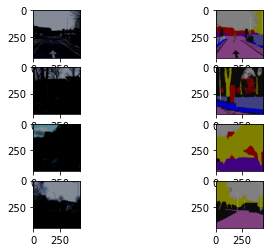

 ex


In [3]:
#testing data loader
local_path = "../input/camvid/CamVid"
augmentations = Compose([RandomHorizontallyFlip(0.5), 
                         RandomScaleCrop((448, 448))
                         ])

dst = camvidLoader(local_path,img_size=[720,960], is_transform=True, augmentations=augmentations)
bs = 4
trainloader = data.DataLoader(dst, batch_size=bs, shuffle=True)
for i, data_samples in enumerate(trainloader):
    imgs, labels = data_samples
    # print(imgs.size())
    imgs = imgs.numpy()[:, ::-1, :, :]
    imgs = np.transpose(imgs, [0, 2, 3, 1])
    newlabels=torch.zeros((labels.shape[0], labels.shape[1], labels.shape[2]))
    # print(type(labels))
    for i in range(len(labels)):
      #print(labels[i,:,:,:].shape)
      # print(labels[i, :, :, :].size(), imgs.shape)
      newlabels[i] = rgb_to_lbl(labels[i,:,:,:], [labels.shape[1], labels.shape[2]])
    labels = newlabels
    f, axarr = plt.subplots(bs, 2)
    for j in range(bs):
        #print(imgs[j].shape, labels.shape)
        axarr[j][0].imshow(imgs[j])
        axarr[j][1].imshow(dst.decode_segmap(labels.numpy()[j]))
    plt.show()
    a = input()
    if a == "ex":
        break
    else:
        plt.close()

In [4]:
# model
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import collections

class ConvLayer(nn.Sequential):
    def __init__(self, in_channels, out_channels, kernel=3, stride=1, dropout=0.1):
        super().__init__()
        self.add_module('conv', nn.Conv2d(in_channels, out_channels, kernel_size=kernel,
                                          stride=stride, padding=kernel//2, bias = False))
        self.add_module('norm', nn.BatchNorm2d(out_channels))
        self.add_module('relu', nn.ReLU(inplace=True))

        #print(kernel, 'x', kernel, 'x', in_channels, 'x', out_channels)

    def forward(self, x):
        return super().forward(x)
        

class BRLayer(nn.Sequential):
    def __init__(self, in_channels):
        super().__init__()
        
        self.add_module('norm', nn.BatchNorm2d(in_channels))
        self.add_module('relu', nn.ReLU(True))
    def forward(self, x):
        return super().forward(x)


class HarDBlock_v2(nn.Module):
    def get_link(self, layer, base_ch, growth_rate, grmul):
        if layer == 0:
          return base_ch, 0, []
        out_channels = growth_rate
        link = []
        for i in range(10):
          dv = 2 ** i
          if layer % dv == 0:
            k = layer - dv
            link.append(k)
            if i > 0:
                out_channels *= grmul
        out_channels = int(int(out_channels + 1) / 2) * 2
        in_channels = 0
        for i in link:
          ch,_,_ = self.get_link(i, base_ch, growth_rate, grmul)
          in_channels += ch
        return out_channels, in_channels, link


    def get_out_ch(self):
        return self.out_channels

    def __init__(self, in_channels, growth_rate, grmul, n_layers, keepBase=False, residual_out=False, dwconv=False, list_out=False):
        super().__init__()
        self.in_channels = in_channels
        self.growth_rate = growth_rate
        self.grmul = grmul
        self.n_layers = n_layers
        self.keepBase = keepBase
        self.links = []
        self.list_out = list_out
        layers_ = []
        self.out_channels = 0

        for i in range(n_layers):
          outch, inch, link = self.get_link(i+1, in_channels, growth_rate, grmul)
          self.links.append(link)
          use_relu = residual_out
          #layers_.append(CatConv2d(inch, outch, (3,3), relu=True))
          layers_.append(nn.Conv2d(inch, outch, (3,3), relu=True))

          if (i % 2 == 0) or (i == n_layers - 1):
            self.out_channels += outch
        print("Blk out =",self.out_channels)
        self.layers = nn.ModuleList(layers_)

    def transform(self, blk):
        for i in range(len(self.layers)):
            self.layers[i].weight[:,:,:,:] = blk.layers[i][0].weight[:,:,:,:]
            self.layers[i].bias[:] = blk.layers[i][0].bias[:]

    def forward(self, x):
        layers_ = [x]
        #self.res = []
        for layer in range(len(self.layers)):
            link = self.links[layer]
            tin = []
            for i in link:
                tin.append(layers_[i])

            out = self.layers[layer](tin)
            #self.res.append(out)
            layers_.append(out)
        t = len(layers_)
        out_ = []
        for i in range(t):
          if (i == 0 and self.keepBase) or \
             (i == t-1) or (i%2 == 1):
              out_.append(layers_[i])
        if self.list_out:
            return out_
        else:
            return torch.cat(out_, 1)



class HarDBlock(nn.Module):
    def get_link(self, layer, base_ch, growth_rate, grmul):
        if layer == 0:
          return base_ch, 0, []
        out_channels = growth_rate
        link = []
        for i in range(10):
          dv = 2 ** i
          if layer % dv == 0:
            k = layer - dv
            link.append(k)
            if i > 0:
                out_channels *= grmul
        out_channels = int(int(out_channels + 1) / 2) * 2
        in_channels = 0
        for i in link:
          ch,_,_ = self.get_link(i, base_ch, growth_rate, grmul)
          in_channels += ch
        return out_channels, in_channels, link

    def get_out_ch(self):
        return self.out_channels
 
    def __init__(self, in_channels, growth_rate, grmul, n_layers, keepBase=False, residual_out=False):
        super().__init__()
        self.in_channels = in_channels
        self.growth_rate = growth_rate
        self.grmul = grmul
        self.n_layers = n_layers
        self.keepBase = keepBase
        self.links = []
        layers_ = []
        self.out_channels = 0 # if upsample else in_channels
        for i in range(n_layers):
          outch, inch, link = self.get_link(i+1, in_channels, growth_rate, grmul)
          self.links.append(link)
          use_relu = residual_out
          layers_.append(ConvLayer(inch, outch))
          if (i % 2 == 0) or (i == n_layers - 1):
            self.out_channels += outch
        #print("Blk out =",self.out_channels)
        self.layers = nn.ModuleList(layers_)


    def forward(self, x):
        layers_ = [x]
        for layer in range(len(self.layers)):
            link = self.links[layer]
            tin = []
            for i in link:
                tin.append(layers_[i])
            if len(tin) > 1:
                x = torch.cat(tin, 1)
            else:
                x = tin[0]
            out = self.layers[layer](x)
            layers_.append(out)
        t = len(layers_)
        out_ = []
        for i in range(t):
          if (i == 0 and self.keepBase) or \
             (i == t-1) or (i%2 == 1):
              out_.append(layers_[i])
        out = torch.cat(out_, 1)
        return out



class TransitionUp(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        #print("upsample",in_channels, out_channels)

    def forward(self, x, skip, concat=True):
        is_v2 = type(skip) is list
        if is_v2:
            skip_x = skip[0]
        else:
            skip_x = skip
        out = F.interpolate(
                x,
                size=(skip_x.size(2), skip_x.size(3)),
                mode="bilinear",
                align_corners=True,
                            )
        if concat:       
          if is_v2:
            out = [out] + skip
          else:                     
            out = torch.cat([out, skip], 1)
          
        return out

class hardnet(nn.Module):
    def __init__(self, n_classes=11):
        super(hardnet, self).__init__()

        first_ch  = [16,24,32,48]
        ch_list = [  64, 96, 160, 224, 320]
        grmul = 1.7
        gr       = [  10,16,18,24,32]
        n_layers = [   4, 4, 8, 8, 8]

        blks = len(n_layers) 
        self.shortcut_layers = []

        self.base = nn.ModuleList([])
        self.base.append (
             ConvLayer(in_channels=3, out_channels=first_ch[0], kernel=3,
                       stride=2) )
        self.base.append ( ConvLayer(first_ch[0], first_ch[1],  kernel=3) )
        self.base.append ( ConvLayer(first_ch[1], first_ch[2],  kernel=3, stride=2) )
        self.base.append ( ConvLayer(first_ch[2], first_ch[3],  kernel=3) )

        skip_connection_channel_counts = []
        ch = first_ch[3]
        for i in range(blks):
            blk = HarDBlock(ch, gr[i], grmul, n_layers[i])
            ch = blk.get_out_ch()
            skip_connection_channel_counts.append(ch)
            self.base.append ( blk )
            if i < blks-1:
              self.shortcut_layers.append(len(self.base)-1)

            self.base.append ( ConvLayer(ch, ch_list[i], kernel=1) )
            ch = ch_list[i]
            
            if i < blks-1:            
              self.base.append ( nn.AvgPool2d(kernel_size=2, stride=2) )


        cur_channels_count = ch
        prev_block_channels = ch
        n_blocks = blks-1
        self.n_blocks =  n_blocks

        # upsampling

        self.transUpBlocks = nn.ModuleList([])
        self.denseBlocksUp = nn.ModuleList([])
        self.conv1x1_up    = nn.ModuleList([])
        
        for i in range(n_blocks-1,-1,-1):
            self.transUpBlocks.append(TransitionUp(prev_block_channels, prev_block_channels))
            cur_channels_count = prev_block_channels + skip_connection_channel_counts[i]
            self.conv1x1_up.append(ConvLayer(cur_channels_count, cur_channels_count//2, kernel=1))
            cur_channels_count = cur_channels_count//2

            blk = HarDBlock(cur_channels_count, gr[i], grmul, n_layers[i])
            
            self.denseBlocksUp.append(blk)
            prev_block_channels = blk.get_out_ch()
            cur_channels_count = prev_block_channels


        self.finalConv = nn.Conv2d(in_channels=cur_channels_count,
               out_channels=n_classes, kernel_size=1, stride=1,
               padding=0, bias=True)
    
    def v2_transform(self):        
        for i in range( len(self.base)):
            if isinstance(self.base[i], HarDBlock):
                blk = self.base[i]
                self.base[i] = HarDBlock_v2(blk.in_channels, blk.growth_rate, blk.grmul, blk.n_layers, list_out=True)
                self.base[i].transform(blk)
            elif isinstance(self.base[i], nn.Sequential):
                blk = self.base[i]
                sz = blk[0].weight.shape
                if sz[2] == 1:
                    #self.base[i] = CatConv2d(sz[1],sz[0],(1,1), relu=True)
                    self.base[i] = nn.Conv2d(sz[1],sz[0],(1,1), relu=True)
                    self.base[i].weight[:,:,:,:] = blk[0].weight[:,:,:,:]
                    self.base[i].bias[:] = blk[0].bias[:]

        for i in range(self.n_blocks):
            blk = self.denseBlocksUp[i]
            self.denseBlocksUp[i] = HarDBlock_v2(blk.in_channels, blk.growth_rate, blk.grmul, blk.n_layers, list_out=False)
            self.denseBlocksUp[i].transform(blk)
  
        for i in range(len(self.conv1x1_up)):
            blk = self.conv1x1_up[i]
            sz = blk[0].weight.shape
            if sz[2] == 1:
                #self.conv1x1_up[i] = CatConv2d(sz[1],sz[0],(1,1), relu=True)
                self.conv1x1_up[i] = nn.Conv2d(sz[1],sz[0],(1,1), relu=True)
                self.conv1x1_up[i].weight[:,:,:,:] = blk[0].weight[:,:,:,:]
                self.conv1x1_up[i].bias[:] = blk[0].bias[:]                 

    def forward(self, x):
        
        skip_connections = []
        size_in = x.size()
        
        
        for i in range(len(self.base)):
            x = self.base[i](x)
            if i in self.shortcut_layers:
                skip_connections.append(x)
        out = x
        
        for i in range(self.n_blocks):
            skip = skip_connections.pop()
            out = self.transUpBlocks[i](out, skip, True)
            out = self.conv1x1_up[i](out)
            out = self.denseBlocksUp[i](out)
        
        out = self.finalConv(out)
        
        out = F.interpolate(
                            out,
                            size=(size_in[2], size_in[3]),
                            mode="bilinear",
                            align_corners=True)
        return out

In [5]:
class runningScore(object):
    def __init__(self, n_classes):
        self.n_classes = n_classes
        self.confusion_matrix = np.zeros((n_classes, n_classes))

    def _fast_hist(self, label_true, label_pred, n_class):
        mask = (label_true >= 0) & (label_true < n_class)
        hist = np.bincount(
            n_class * label_true[mask].astype(int) + label_pred[mask], minlength=n_class ** 2
        ).reshape(n_class, n_class)
        return hist

    def update(self, label_trues, label_preds):
        for lt, lp in zip(label_trues, label_preds):
            self.confusion_matrix += self._fast_hist(lt.flatten(), lp.flatten(), self.n_classes)

    def get_scores(self):
        """Returns accuracy score evaluation result.
            - overall accuracy
            - mean accuracy
            - mean IU
            - fwavacc
        """
        hist = self.confusion_matrix
        acc = np.diag(hist).sum() / hist.sum()
        acc_cls = np.diag(hist) / hist.sum(axis=1)
        acc_cls = np.nanmean(acc_cls)
        iu = np.diag(hist) / (hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist))
        mean_iu = np.nanmean(iu)
        freq = hist.sum(axis=1) / hist.sum()
        fwavacc = (freq[freq > 0] * iu[freq > 0]).sum()
        cls_iu = dict(zip(range(self.n_classes), iu))

        return (
            {
                "Overall Acc: \t": acc,
                "Mean Acc : \t": acc_cls,
                "FreqW Acc : \t": fwavacc,
                "Mean IoU : \t": mean_iu,
            },
            cls_iu,
        )

    def reset(self):
        self.confusion_matrix = np.zeros((self.n_classes, self.n_classes))


class averageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


In [9]:
import time
from tqdm import tqdm

def weights_init(m):
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_normal_(m.weight)


# Setup seeds
# torch.manual_seed(1337)
# torch.cuda.manual_seed(1337)
# np.random.seed(1337)
# random.seed(1337)

# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Setup Augmentations
data_aug = Compose([RandomHorizontallyFlip(0.5), 
                    RandomScaleCrop((448, 448))
                    ])

# Setup Dataloader

data_loader = camvidLoader
data_path = '../input/camvid/CamVid'

t_loader = data_loader(
    data_path,
    is_transform=True,
    split='train',
    img_size=(720, 960),
    augmentations=data_aug,
)

v_loader = data_loader(
    data_path,
    is_transform=True,
    split='val',
    img_size=(720, 960),
)

n_classes = t_loader.n_classes
trainloader = data.DataLoader(
    t_loader,
    batch_size=16,
    shuffle=True,
)

valloader = data.DataLoader(
    v_loader, 
    batch_size=16, 
)

# Setup Metrics
running_metrics_val = runningScore(n_classes)

# Setup Model

model = hardnet()

total_params = sum(p.numel() for p in model.parameters())
print( 'Parameters:',total_params )

model = torch.nn.DataParallel(model, device_ids=range(torch.cuda.device_count()))
model.apply(weights_init)
optimizer_cls = torch.optim.Adam

optimizer = optimizer_cls(model.parameters(), lr=1e-3, betas=(0.9, 0.999), weight_decay=2.5e-5)
print("Using optimizer {}".format(optimizer))

num_epochs = 400
per_epoch = len(trainloader)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=400, eta_min=1e-6)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=11)
print("Using loss {}".format(loss_fn))

start_epoch = 0
resume = True
file_checkpoint = '../input/models-hardnet-camvid/hardnet_CamVid_checkpoint-flip-scale-crop.pkl'
if resume is not None:
    if os.path.isfile(file_checkpoint):
        print("Loading model and optimizer from checkpoint '{}'".format(file_checkpoint))
              
        checkpoint = torch.load(file_checkpoint)
        model.load_state_dict(checkpoint["model_state"])
        optimizer.load_state_dict(checkpoint["optimizer_state"])
        scheduler.load_state_dict(checkpoint["scheduler_state"])
        start_epoch = checkpoint["epoch"] + 1

    else:
        print("No checkpoint found at '{}'".format(file_checkpoint))

val_loss_meter = averageMeter()
time_meter = averageMeter()

best_iou = -100.0
flag = True
loss_all = 0
loss_n = 0
for epoch in range(start_epoch, num_epochs):
    curr_iter = 0
    for (images, labels) in trainloader:
        start_ts = time.time()
        curr_iter += 1
        model.train()
        images = images.to(device)
        newlabels = torch.zeros((labels.shape[0], labels.shape[1], labels.shape[2]))
        for j in range(len(labels)):
          newlabels[j] = rgb_to_lbl(labels[j, :, :, :], [labels.shape[1], labels.shape[2]])
        labels = newlabels
        labels = labels.to(device)
        labels = labels.long()
        
        optimizer.zero_grad()
        outputs = model(images)

        loss = loss_fn(input=outputs, target=labels)
        loss.backward()
        optimizer.step()
        c_lr = scheduler.get_last_lr()

        time_meter.update(time.time() - start_ts)
        loss_all += loss.item()
        loss_n += 1
                
        if curr_iter % 6 == 0:
            fmt_str = "Epoch {:d} Batch [{:d}/{:d}]  Loss: {:.4f}  Time/Image: {:.4f}  lr={:.6f}"
            print_str = fmt_str.format(
                epoch,
                curr_iter,
                per_epoch,
                loss_all / loss_n,
                time_meter.avg / 16,
                c_lr[0],
            )
            

            print(print_str)
            time_meter.reset()
    scheduler.step()
    torch.cuda.empty_cache()
    model.eval()
    loss_all = 0
    loss_n = 0
    with torch.no_grad():
        for i_val, (images_val, labels_val) in tqdm(enumerate(valloader)):
            images_val = images_val.to(device)
            newlabels = torch.zeros((labels_val.shape[0], labels_val.shape[1], labels_val.shape[2]))
            for j in range(len(labels_val)):
              newlabels[j] = rgb_to_lbl(labels_val[j, :, :, :], [labels_val.shape[1], labels_val.shape[2]])
            labels_val = newlabels
            labels_val = labels_val.to(device)
            labels_val = labels_val.long()
            outputs = model(images_val)
            val_loss = loss_fn(input=outputs, target=labels_val)

            pred = outputs.data.max(1)[1].cpu().numpy()
            gt = labels_val.data.cpu().numpy()

            running_metrics_val.update(gt, pred)
            val_loss_meter.update(val_loss.item())

    print(format("Epoch %d Iter %d Val Loss: %.4f" % (epoch, (epoch + 1) * per_epoch, val_loss_meter.avg)))

    score, class_iou = running_metrics_val.get_scores()
    for k, v in score.items():
        print(k, v)
        
    if score["Mean IoU : \t"] >= best_iou:
                    best_iou = score["Mean IoU : \t"]
                    state = {
                        "epoch": i + 1,
                        "model_state": model.state_dict(),
                        "best_iou": best_iou,
                    }
                    save_path = os.path.join(
                       './',
                        "{}_{}_best_model.pkl".format('hardnet', 'CamVid'),
                    )
                    torch.save(state, save_path)

    val_loss_meter.reset()
    running_metrics_val.reset()
    
    state = {
          "epoch": epoch,
          "model_state": model.state_dict(),
          "optimizer_state": optimizer.state_dict(),
          "scheduler_state": scheduler.state_dict(),
    }
    save_path = os.path.join(
        './',
        "{}_{}_checkpoint.pkl".format('hardnet', 'CamVid'),
    )
    torch.save(state, save_path)
    torch.cuda.empty_cache()

  

Parameters: 4118865
Using optimizer Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 2.5e-05
)
Using loss CrossEntropyLoss()
Loading model and optimizer from checkpoint '../input/models-hardnet-camvid/hardnet_CamVid_checkpoint-flip-scale-crop.pkl'
Epoch 264 Batch [6/24]  Loss: 0.1829  Time/Image: 0.0821  lr=0.000260
Epoch 264 Batch [12/24]  Loss: 0.1838  Time/Image: 0.0219  lr=0.000260
Epoch 264 Batch [18/24]  Loss: 0.1967  Time/Image: 0.0212  lr=0.000260
Epoch 264 Batch [24/24]  Loss: 0.2213  Time/Image: 0.0187  lr=0.000260


7it [00:17,  2.43s/it]


Epoch 264 Iter 6360 Val Loss: 0.1566
Overall Acc: 	 0.9455065310254724
Mean Acc : 	 0.7404010437728652
FreqW Acc : 	 0.8992898173012656
Mean IoU : 	 0.6875179499402108
Epoch 265 Batch [6/24]  Loss: 0.1983  Time/Image: 0.0225  lr=0.000256
Epoch 265 Batch [12/24]  Loss: 0.1925  Time/Image: 0.0216  lr=0.000256
Epoch 265 Batch [18/24]  Loss: 0.1958  Time/Image: 0.0213  lr=0.000256
Epoch 265 Batch [24/24]  Loss: 0.2788  Time/Image: 0.0209  lr=0.000256


7it [00:13,  1.94s/it]


Epoch 265 Iter 6384 Val Loss: 0.1636
Overall Acc: 	 0.9438714676032306
Mean Acc : 	 0.734813521993365
FreqW Acc : 	 0.8961279438122272
Mean IoU : 	 0.6832590481772568
Epoch 266 Batch [6/24]  Loss: 0.1996  Time/Image: 0.0216  lr=0.000253
Epoch 266 Batch [12/24]  Loss: 0.2038  Time/Image: 0.0215  lr=0.000253
Epoch 266 Batch [18/24]  Loss: 0.1982  Time/Image: 0.0226  lr=0.000253
Epoch 266 Batch [24/24]  Loss: 0.2215  Time/Image: 0.0184  lr=0.000253


7it [00:13,  1.89s/it]


Epoch 266 Iter 6408 Val Loss: 0.1630
Overall Acc: 	 0.9449819029057455
Mean Acc : 	 0.7412947604451049
FreqW Acc : 	 0.8987556624579485
Mean IoU : 	 0.6858153024223373
Epoch 267 Batch [6/24]  Loss: 0.1938  Time/Image: 0.0235  lr=0.000250
Epoch 267 Batch [12/24]  Loss: 0.1877  Time/Image: 0.0214  lr=0.000250
Epoch 267 Batch [18/24]  Loss: 0.1878  Time/Image: 0.0215  lr=0.000250
Epoch 267 Batch [24/24]  Loss: 0.1926  Time/Image: 0.0185  lr=0.000250


7it [00:13,  1.97s/it]


Epoch 267 Iter 6432 Val Loss: 0.1542
Overall Acc: 	 0.9476028126833507
Mean Acc : 	 0.7578761638802622
FreqW Acc : 	 0.9036331845162464
Mean IoU : 	 0.698865634692532
Epoch 268 Batch [6/24]  Loss: 0.2011  Time/Image: 0.0217  lr=0.000246
Epoch 268 Batch [12/24]  Loss: 0.1974  Time/Image: 0.0212  lr=0.000246
Epoch 268 Batch [18/24]  Loss: 0.1923  Time/Image: 0.0215  lr=0.000246
Epoch 268 Batch [24/24]  Loss: 0.2247  Time/Image: 0.0191  lr=0.000246


7it [00:12,  1.83s/it]


Epoch 268 Iter 6456 Val Loss: 0.1552
Overall Acc: 	 0.9459889179872832
Mean Acc : 	 0.7487905096835871
FreqW Acc : 	 0.901533123548839
Mean IoU : 	 0.6849917329533673
Epoch 269 Batch [6/24]  Loss: 0.1754  Time/Image: 0.0213  lr=0.000243
Epoch 269 Batch [12/24]  Loss: 0.1891  Time/Image: 0.0229  lr=0.000243
Epoch 269 Batch [18/24]  Loss: 0.1928  Time/Image: 0.0210  lr=0.000243
Epoch 269 Batch [24/24]  Loss: 0.2035  Time/Image: 0.0185  lr=0.000243


7it [00:13,  1.91s/it]


Epoch 269 Iter 6480 Val Loss: 0.1546
Overall Acc: 	 0.946864122039199
Mean Acc : 	 0.772816458596581
FreqW Acc : 	 0.9027934715634822
Mean IoU : 	 0.70432539058035
Epoch 270 Batch [6/24]  Loss: 0.1817  Time/Image: 0.0225  lr=0.000240
Epoch 270 Batch [12/24]  Loss: 0.1888  Time/Image: 0.0228  lr=0.000240
Epoch 270 Batch [18/24]  Loss: 0.1970  Time/Image: 0.0215  lr=0.000240
Epoch 270 Batch [24/24]  Loss: 0.2092  Time/Image: 0.0199  lr=0.000240


7it [00:13,  1.89s/it]


Epoch 270 Iter 6504 Val Loss: 0.1536
Overall Acc: 	 0.9473640024896605
Mean Acc : 	 0.7578274639178804
FreqW Acc : 	 0.9036985835977498
Mean IoU : 	 0.6957877164911342
Epoch 271 Batch [6/24]  Loss: 0.1865  Time/Image: 0.0216  lr=0.000236
Epoch 271 Batch [12/24]  Loss: 0.1910  Time/Image: 0.0254  lr=0.000236
Epoch 271 Batch [18/24]  Loss: 0.1927  Time/Image: 0.0211  lr=0.000236
Epoch 271 Batch [24/24]  Loss: 0.1944  Time/Image: 0.0184  lr=0.000236


7it [00:13,  1.89s/it]


Epoch 271 Iter 6528 Val Loss: 0.1570
Overall Acc: 	 0.9462897899430031
Mean Acc : 	 0.7604191489362676
FreqW Acc : 	 0.9013967558262836
Mean IoU : 	 0.6979149206618839
Epoch 272 Batch [6/24]  Loss: 0.2274  Time/Image: 0.0217  lr=0.000233
Epoch 272 Batch [12/24]  Loss: 0.2068  Time/Image: 0.0218  lr=0.000233
Epoch 272 Batch [18/24]  Loss: 0.2045  Time/Image: 0.0229  lr=0.000233
Epoch 272 Batch [24/24]  Loss: 0.1980  Time/Image: 0.0192  lr=0.000233


7it [00:13,  1.88s/it]


Epoch 272 Iter 6552 Val Loss: 0.1548
Overall Acc: 	 0.9460116113753128
Mean Acc : 	 0.7758460360739462
FreqW Acc : 	 0.9012967060112472
Mean IoU : 	 0.7027406595833822
Epoch 273 Batch [6/24]  Loss: 0.2043  Time/Image: 0.0216  lr=0.000230
Epoch 273 Batch [12/24]  Loss: 0.1988  Time/Image: 0.0228  lr=0.000230
Epoch 273 Batch [18/24]  Loss: 0.1982  Time/Image: 0.0213  lr=0.000230
Epoch 273 Batch [24/24]  Loss: 0.2081  Time/Image: 0.0185  lr=0.000230


7it [00:12,  1.85s/it]


Epoch 273 Iter 6576 Val Loss: 0.1496
Overall Acc: 	 0.9479834806258329
Mean Acc : 	 0.7782697460338465
FreqW Acc : 	 0.9046924034847013
Mean IoU : 	 0.7114422616024336
Epoch 274 Batch [6/24]  Loss: 0.2044  Time/Image: 0.0222  lr=0.000226
Epoch 274 Batch [12/24]  Loss: 0.1956  Time/Image: 0.0219  lr=0.000226
Epoch 274 Batch [18/24]  Loss: 0.1920  Time/Image: 0.0212  lr=0.000226
Epoch 274 Batch [24/24]  Loss: 0.1953  Time/Image: 0.0185  lr=0.000226


7it [00:13,  1.91s/it]


Epoch 274 Iter 6600 Val Loss: 0.1538
Overall Acc: 	 0.9464316155936509
Mean Acc : 	 0.7759039416149598
FreqW Acc : 	 0.9016595747948779
Mean IoU : 	 0.7087875255357742
Epoch 275 Batch [6/24]  Loss: 0.1909  Time/Image: 0.0219  lr=0.000223
Epoch 275 Batch [12/24]  Loss: 0.1774  Time/Image: 0.0222  lr=0.000223
Epoch 275 Batch [18/24]  Loss: 0.1808  Time/Image: 0.0211  lr=0.000223
Epoch 275 Batch [24/24]  Loss: 0.1860  Time/Image: 0.0182  lr=0.000223


7it [00:12,  1.83s/it]


Epoch 275 Iter 6624 Val Loss: 0.1490
Overall Acc: 	 0.9483046546578308
Mean Acc : 	 0.7651610013510965
FreqW Acc : 	 0.905130961232758
Mean IoU : 	 0.7035672630731422
Epoch 276 Batch [6/24]  Loss: 0.1743  Time/Image: 0.0214  lr=0.000220
Epoch 276 Batch [12/24]  Loss: 0.1820  Time/Image: 0.0225  lr=0.000220
Epoch 276 Batch [18/24]  Loss: 0.1861  Time/Image: 0.0222  lr=0.000220
Epoch 276 Batch [24/24]  Loss: 0.1821  Time/Image: 0.0185  lr=0.000220


7it [00:13,  1.92s/it]


Epoch 276 Iter 6648 Val Loss: 0.1512
Overall Acc: 	 0.9476412502111656
Mean Acc : 	 0.7747678940383989
FreqW Acc : 	 0.9046640952757283
Mean IoU : 	 0.7057233639088458
Epoch 277 Batch [6/24]  Loss: 0.2076  Time/Image: 0.0213  lr=0.000217
Epoch 277 Batch [12/24]  Loss: 0.2013  Time/Image: 0.0213  lr=0.000217
Epoch 277 Batch [18/24]  Loss: 0.1962  Time/Image: 0.0221  lr=0.000217
Epoch 277 Batch [24/24]  Loss: 0.2330  Time/Image: 0.0193  lr=0.000217


7it [00:12,  1.84s/it]


Epoch 277 Iter 6672 Val Loss: 0.1525
Overall Acc: 	 0.9481206680946275
Mean Acc : 	 0.7616637524755777
FreqW Acc : 	 0.9044976394074654
Mean IoU : 	 0.6997496712433322
Epoch 278 Batch [6/24]  Loss: 0.1658  Time/Image: 0.0232  lr=0.000213
Epoch 278 Batch [12/24]  Loss: 0.1785  Time/Image: 0.0226  lr=0.000213
Epoch 278 Batch [18/24]  Loss: 0.1740  Time/Image: 0.0217  lr=0.000213
Epoch 278 Batch [24/24]  Loss: 0.1805  Time/Image: 0.0194  lr=0.000213


7it [00:12,  1.84s/it]


Epoch 278 Iter 6696 Val Loss: 0.1474
Overall Acc: 	 0.9492961984338095
Mean Acc : 	 0.7720695146090614
FreqW Acc : 	 0.9071179414218717
Mean IoU : 	 0.7085805531774212
Epoch 279 Batch [6/24]  Loss: 0.2089  Time/Image: 0.0221  lr=0.000210
Epoch 279 Batch [12/24]  Loss: 0.2013  Time/Image: 0.0220  lr=0.000210
Epoch 279 Batch [18/24]  Loss: 0.1923  Time/Image: 0.0213  lr=0.000210
Epoch 279 Batch [24/24]  Loss: 0.2278  Time/Image: 0.0199  lr=0.000210


7it [00:12,  1.85s/it]


Epoch 279 Iter 6720 Val Loss: 0.1456
Overall Acc: 	 0.9493119746717394
Mean Acc : 	 0.7818786348246483
FreqW Acc : 	 0.9071537015013454
Mean IoU : 	 0.7145961207988476
Epoch 280 Batch [6/24]  Loss: 0.1979  Time/Image: 0.0213  lr=0.000207
Epoch 280 Batch [12/24]  Loss: 0.1920  Time/Image: 0.0248  lr=0.000207
Epoch 280 Batch [18/24]  Loss: 0.1887  Time/Image: 0.0212  lr=0.000207
Epoch 280 Batch [24/24]  Loss: 0.2049  Time/Image: 0.0184  lr=0.000207


7it [00:13,  1.93s/it]


Epoch 280 Iter 6744 Val Loss: 0.1521
Overall Acc: 	 0.9473870489572773
Mean Acc : 	 0.7546801174490103
FreqW Acc : 	 0.9026705905058885
Mean IoU : 	 0.7020097783858733
Epoch 281 Batch [6/24]  Loss: 0.1735  Time/Image: 0.0215  lr=0.000204
Epoch 281 Batch [12/24]  Loss: 0.1884  Time/Image: 0.0215  lr=0.000204
Epoch 281 Batch [18/24]  Loss: 0.1831  Time/Image: 0.0220  lr=0.000204
Epoch 281 Batch [24/24]  Loss: 0.1991  Time/Image: 0.0187  lr=0.000204


7it [00:13,  1.90s/it]


Epoch 281 Iter 6768 Val Loss: 0.1527
Overall Acc: 	 0.9473303957325645
Mean Acc : 	 0.7725440576219312
FreqW Acc : 	 0.9036863013249675
Mean IoU : 	 0.7059082906609201
Epoch 282 Batch [6/24]  Loss: 0.1732  Time/Image: 0.0214  lr=0.000201
Epoch 282 Batch [12/24]  Loss: 0.1795  Time/Image: 0.0211  lr=0.000201
Epoch 282 Batch [18/24]  Loss: 0.1814  Time/Image: 0.0229  lr=0.000201
Epoch 282 Batch [24/24]  Loss: 0.1823  Time/Image: 0.0189  lr=0.000201


7it [00:12,  1.85s/it]


Epoch 282 Iter 6792 Val Loss: 0.1474
Overall Acc: 	 0.9492228060268374
Mean Acc : 	 0.7843914425201365
FreqW Acc : 	 0.9068500537171054
Mean IoU : 	 0.717564736781275
Epoch 283 Batch [6/24]  Loss: 0.1820  Time/Image: 0.0245  lr=0.000197
Epoch 283 Batch [12/24]  Loss: 0.1845  Time/Image: 0.0212  lr=0.000197
Epoch 283 Batch [18/24]  Loss: 0.1757  Time/Image: 0.0213  lr=0.000197
Epoch 283 Batch [24/24]  Loss: 0.2152  Time/Image: 0.0183  lr=0.000197


7it [00:13,  1.90s/it]


Epoch 283 Iter 6816 Val Loss: 0.1515
Overall Acc: 	 0.9488663882323838
Mean Acc : 	 0.7630493778431163
FreqW Acc : 	 0.9060325958889882
Mean IoU : 	 0.7022837754838571
Epoch 284 Batch [6/24]  Loss: 0.1991  Time/Image: 0.0216  lr=0.000194
Epoch 284 Batch [12/24]  Loss: 0.1900  Time/Image: 0.0226  lr=0.000194
Epoch 284 Batch [18/24]  Loss: 0.1850  Time/Image: 0.0229  lr=0.000194
Epoch 284 Batch [24/24]  Loss: 0.1944  Time/Image: 0.0187  lr=0.000194


7it [00:12,  1.84s/it]


Epoch 284 Iter 6840 Val Loss: 0.1443
Overall Acc: 	 0.9499117605963758
Mean Acc : 	 0.7767379054075844
FreqW Acc : 	 0.9078150942202114
Mean IoU : 	 0.7153817667686773
Epoch 285 Batch [6/24]  Loss: 0.1790  Time/Image: 0.0214  lr=0.000191
Epoch 285 Batch [12/24]  Loss: 0.1747  Time/Image: 0.0230  lr=0.000191
Epoch 285 Batch [18/24]  Loss: 0.1776  Time/Image: 0.0236  lr=0.000191
Epoch 285 Batch [24/24]  Loss: 0.1950  Time/Image: 0.0183  lr=0.000191


7it [00:13,  1.95s/it]


Epoch 285 Iter 6864 Val Loss: 0.1605
Overall Acc: 	 0.9459131342685598
Mean Acc : 	 0.7857672855116903
FreqW Acc : 	 0.9012359036909997
Mean IoU : 	 0.7099191380263378
Epoch 286 Batch [6/24]  Loss: 0.1876  Time/Image: 0.0213  lr=0.000188
Epoch 286 Batch [12/24]  Loss: 0.2020  Time/Image: 0.0212  lr=0.000188
Epoch 286 Batch [18/24]  Loss: 0.1934  Time/Image: 0.0219  lr=0.000188
Epoch 286 Batch [24/24]  Loss: 0.1894  Time/Image: 0.0194  lr=0.000188


7it [00:12,  1.83s/it]


Epoch 286 Iter 6888 Val Loss: 0.1505
Overall Acc: 	 0.9476568178111575
Mean Acc : 	 0.7822857341352474
FreqW Acc : 	 0.9040729937118458
Mean IoU : 	 0.7108664545087143
Epoch 287 Batch [6/24]  Loss: 0.1914  Time/Image: 0.0232  lr=0.000185
Epoch 287 Batch [12/24]  Loss: 0.1949  Time/Image: 0.0214  lr=0.000185
Epoch 287 Batch [18/24]  Loss: 0.1955  Time/Image: 0.0212  lr=0.000185
Epoch 287 Batch [24/24]  Loss: 0.1964  Time/Image: 0.0180  lr=0.000185


7it [00:12,  1.84s/it]


Epoch 287 Iter 6912 Val Loss: 0.1467
Overall Acc: 	 0.9490778668561912
Mean Acc : 	 0.7785934440682349
FreqW Acc : 	 0.9065592882009086
Mean IoU : 	 0.7127252946069546
Epoch 288 Batch [6/24]  Loss: 0.1804  Time/Image: 0.0225  lr=0.000182
Epoch 288 Batch [12/24]  Loss: 0.1901  Time/Image: 0.0229  lr=0.000182
Epoch 288 Batch [18/24]  Loss: 0.1840  Time/Image: 0.0210  lr=0.000182
Epoch 288 Batch [24/24]  Loss: 0.1946  Time/Image: 0.0189  lr=0.000182


7it [00:13,  1.92s/it]


Epoch 288 Iter 6936 Val Loss: 0.1446
Overall Acc: 	 0.9502167732127119
Mean Acc : 	 0.7835759597641831
FreqW Acc : 	 0.9085953989174909
Mean IoU : 	 0.7178371684096827
Epoch 289 Batch [6/24]  Loss: 0.1732  Time/Image: 0.0215  lr=0.000179
Epoch 289 Batch [12/24]  Loss: 0.1687  Time/Image: 0.0212  lr=0.000179
Epoch 289 Batch [18/24]  Loss: 0.1767  Time/Image: 0.0226  lr=0.000179
Epoch 289 Batch [24/24]  Loss: 0.1778  Time/Image: 0.0186  lr=0.000179


7it [00:13,  1.90s/it]


Epoch 289 Iter 6960 Val Loss: 0.1477
Overall Acc: 	 0.9492097741802463
Mean Acc : 	 0.7689183949021691
FreqW Acc : 	 0.9064526761030388
Mean IoU : 	 0.71040414322882
Epoch 290 Batch [6/24]  Loss: 0.1803  Time/Image: 0.0230  lr=0.000176
Epoch 290 Batch [12/24]  Loss: 0.1739  Time/Image: 0.0212  lr=0.000176
Epoch 290 Batch [18/24]  Loss: 0.1769  Time/Image: 0.0218  lr=0.000176
Epoch 290 Batch [24/24]  Loss: 0.2234  Time/Image: 0.0185  lr=0.000176


7it [00:13,  1.93s/it]


Epoch 290 Iter 6984 Val Loss: 0.1494
Overall Acc: 	 0.9481607747259468
Mean Acc : 	 0.7814998614524206
FreqW Acc : 	 0.9049426506910029
Mean IoU : 	 0.7141324603570306
Epoch 291 Batch [6/24]  Loss: 0.1892  Time/Image: 0.0213  lr=0.000173
Epoch 291 Batch [12/24]  Loss: 0.1953  Time/Image: 0.0215  lr=0.000173
Epoch 291 Batch [18/24]  Loss: 0.1864  Time/Image: 0.0248  lr=0.000173
Epoch 291 Batch [24/24]  Loss: 0.1860  Time/Image: 0.0185  lr=0.000173


7it [00:13,  1.86s/it]


Epoch 291 Iter 7008 Val Loss: 0.1494
Overall Acc: 	 0.9489119675973084
Mean Acc : 	 0.7613410662584442
FreqW Acc : 	 0.905717644992197
Mean IoU : 	 0.7057945246806848
Epoch 292 Batch [6/24]  Loss: 0.1792  Time/Image: 0.0216  lr=0.000170
Epoch 292 Batch [12/24]  Loss: 0.1807  Time/Image: 0.0230  lr=0.000170
Epoch 292 Batch [18/24]  Loss: 0.1794  Time/Image: 0.0214  lr=0.000170
Epoch 292 Batch [24/24]  Loss: 0.1769  Time/Image: 0.0188  lr=0.000170


7it [00:13,  1.90s/it]


Epoch 292 Iter 7032 Val Loss: 0.1448
Overall Acc: 	 0.9494465621908447
Mean Acc : 	 0.7776450266345648
FreqW Acc : 	 0.907019791538993
Mean IoU : 	 0.7144504556358942
Epoch 293 Batch [6/24]  Loss: 0.1870  Time/Image: 0.0214  lr=0.000167
Epoch 293 Batch [12/24]  Loss: 0.1969  Time/Image: 0.0216  lr=0.000167
Epoch 293 Batch [18/24]  Loss: 0.1851  Time/Image: 0.0229  lr=0.000167
Epoch 293 Batch [24/24]  Loss: 0.2539  Time/Image: 0.0188  lr=0.000167


7it [00:13,  1.87s/it]


Epoch 293 Iter 7056 Val Loss: 0.1526
Overall Acc: 	 0.947009863663453
Mean Acc : 	 0.7581355443028294
FreqW Acc : 	 0.9020583458404693
Mean IoU : 	 0.7033494716448881
Epoch 294 Batch [6/24]  Loss: 0.1809  Time/Image: 0.0215  lr=0.000164
Epoch 294 Batch [12/24]  Loss: 0.1650  Time/Image: 0.0231  lr=0.000164
Epoch 294 Batch [18/24]  Loss: 0.1632  Time/Image: 0.0226  lr=0.000164
Epoch 294 Batch [24/24]  Loss: 0.1687  Time/Image: 0.0186  lr=0.000164


7it [00:13,  1.87s/it]


Epoch 294 Iter 7080 Val Loss: 0.1431
Overall Acc: 	 0.9499693125691294
Mean Acc : 	 0.7752733274687387
FreqW Acc : 	 0.9079709414948642
Mean IoU : 	 0.7138441593381747
Epoch 295 Batch [6/24]  Loss: 0.1852  Time/Image: 0.0213  lr=0.000161
Epoch 295 Batch [12/24]  Loss: 0.1978  Time/Image: 0.0215  lr=0.000161
Epoch 295 Batch [18/24]  Loss: 0.1892  Time/Image: 0.0216  lr=0.000161
Epoch 295 Batch [24/24]  Loss: 0.2965  Time/Image: 0.0200  lr=0.000161


7it [00:13,  1.89s/it]


Epoch 295 Iter 7104 Val Loss: 0.1525
Overall Acc: 	 0.9473123565754605
Mean Acc : 	 0.7787480503286065
FreqW Acc : 	 0.9036584044131847
Mean IoU : 	 0.7077678716691553
Epoch 296 Batch [6/24]  Loss: 0.1973  Time/Image: 0.0223  lr=0.000159
Epoch 296 Batch [12/24]  Loss: 0.1853  Time/Image: 0.0223  lr=0.000159
Epoch 296 Batch [18/24]  Loss: 0.1910  Time/Image: 0.0216  lr=0.000159
Epoch 296 Batch [24/24]  Loss: 0.2614  Time/Image: 0.0188  lr=0.000159


7it [00:13,  1.86s/it]


Epoch 296 Iter 7128 Val Loss: 0.1680
Overall Acc: 	 0.9422478311203643
Mean Acc : 	 0.7443366408885904
FreqW Acc : 	 0.8936438364243317
Mean IoU : 	 0.6862892457413946
Epoch 297 Batch [6/24]  Loss: 0.1680  Time/Image: 0.0242  lr=0.000156
Epoch 297 Batch [12/24]  Loss: 0.1805  Time/Image: 0.0220  lr=0.000156
Epoch 297 Batch [18/24]  Loss: 0.1855  Time/Image: 0.0212  lr=0.000156
Epoch 297 Batch [24/24]  Loss: 0.1946  Time/Image: 0.0184  lr=0.000156


7it [00:13,  1.91s/it]


Epoch 297 Iter 7152 Val Loss: 0.1495
Overall Acc: 	 0.9484516160115687
Mean Acc : 	 0.7803365784012685
FreqW Acc : 	 0.9051479647175805
Mean IoU : 	 0.7122530710760975
Epoch 298 Batch [6/24]  Loss: 0.1679  Time/Image: 0.0214  lr=0.000153
Epoch 298 Batch [12/24]  Loss: 0.1706  Time/Image: 0.0213  lr=0.000153
Epoch 298 Batch [18/24]  Loss: 0.1728  Time/Image: 0.0236  lr=0.000153
Epoch 298 Batch [24/24]  Loss: 0.1876  Time/Image: 0.0199  lr=0.000153


7it [00:13,  1.87s/it]


Epoch 298 Iter 7176 Val Loss: 0.1459
Overall Acc: 	 0.9490972541353564
Mean Acc : 	 0.7774848924588422
FreqW Acc : 	 0.9062873124692757
Mean IoU : 	 0.7133829879462158
Epoch 299 Batch [6/24]  Loss: 0.1757  Time/Image: 0.0227  lr=0.000150
Epoch 299 Batch [12/24]  Loss: 0.1875  Time/Image: 0.0215  lr=0.000150
Epoch 299 Batch [18/24]  Loss: 0.1862  Time/Image: 0.0214  lr=0.000150
Epoch 299 Batch [24/24]  Loss: 0.1844  Time/Image: 0.0184  lr=0.000150


7it [00:13,  1.92s/it]


Epoch 299 Iter 7200 Val Loss: 0.1479
Overall Acc: 	 0.9486301298411665
Mean Acc : 	 0.7809190260424251
FreqW Acc : 	 0.9058608280058262
Mean IoU : 	 0.7144552653771583
Epoch 300 Batch [6/24]  Loss: 0.2066  Time/Image: 0.0217  lr=0.000147
Epoch 300 Batch [12/24]  Loss: 0.1858  Time/Image: 0.0214  lr=0.000147
Epoch 300 Batch [18/24]  Loss: 0.1917  Time/Image: 0.0231  lr=0.000147
Epoch 300 Batch [24/24]  Loss: 0.1997  Time/Image: 0.0186  lr=0.000147


7it [00:12,  1.82s/it]


Epoch 300 Iter 7224 Val Loss: 0.1528
Overall Acc: 	 0.9462397007888023
Mean Acc : 	 0.7676125046264258
FreqW Acc : 	 0.9014254842936398
Mean IoU : 	 0.704920590889986
Epoch 301 Batch [6/24]  Loss: 0.1718  Time/Image: 0.0214  lr=0.000145
Epoch 301 Batch [12/24]  Loss: 0.1725  Time/Image: 0.0230  lr=0.000145
Epoch 301 Batch [18/24]  Loss: 0.1842  Time/Image: 0.0227  lr=0.000145
Epoch 301 Batch [24/24]  Loss: 0.1802  Time/Image: 0.0184  lr=0.000145


7it [00:13,  1.92s/it]


Epoch 301 Iter 7248 Val Loss: 0.1462
Overall Acc: 	 0.948686333691859
Mean Acc : 	 0.7722398475153753
FreqW Acc : 	 0.9057567990069653
Mean IoU : 	 0.7087828872610976
Epoch 302 Batch [6/24]  Loss: 0.1837  Time/Image: 0.0212  lr=0.000142
Epoch 302 Batch [12/24]  Loss: 0.1946  Time/Image: 0.0216  lr=0.000142
Epoch 302 Batch [18/24]  Loss: 0.1866  Time/Image: 0.0217  lr=0.000142
Epoch 302 Batch [24/24]  Loss: 0.2020  Time/Image: 0.0184  lr=0.000142


7it [00:12,  1.83s/it]


Epoch 302 Iter 7272 Val Loss: 0.1552
Overall Acc: 	 0.9460331010829304
Mean Acc : 	 0.7702535373365502
FreqW Acc : 	 0.9009468684706017
Mean IoU : 	 0.7040965069853672
Epoch 303 Batch [6/24]  Loss: 0.1709  Time/Image: 0.0227  lr=0.000139
Epoch 303 Batch [12/24]  Loss: 0.1763  Time/Image: 0.0214  lr=0.000139
Epoch 303 Batch [18/24]  Loss: 0.1793  Time/Image: 0.0212  lr=0.000139
Epoch 303 Batch [24/24]  Loss: 0.2442  Time/Image: 0.0183  lr=0.000139


7it [00:13,  1.95s/it]


Epoch 303 Iter 7296 Val Loss: 0.1578
Overall Acc: 	 0.9462509351393119
Mean Acc : 	 0.7591407428354551
FreqW Acc : 	 0.9012085965715337
Mean IoU : 	 0.6998211458441262
Epoch 304 Batch [6/24]  Loss: 0.1828  Time/Image: 0.0221  lr=0.000136
Epoch 304 Batch [12/24]  Loss: 0.1712  Time/Image: 0.0214  lr=0.000136
Epoch 304 Batch [18/24]  Loss: 0.1726  Time/Image: 0.0216  lr=0.000136
Epoch 304 Batch [24/24]  Loss: 0.2057  Time/Image: 0.0200  lr=0.000136


7it [00:12,  1.82s/it]


Epoch 304 Iter 7320 Val Loss: 0.1557
Overall Acc: 	 0.9464948810360921
Mean Acc : 	 0.7526667470709995
FreqW Acc : 	 0.9009276838523502
Mean IoU : 	 0.698872621619055
Epoch 305 Batch [6/24]  Loss: 0.1761  Time/Image: 0.0213  lr=0.000134
Epoch 305 Batch [12/24]  Loss: 0.1802  Time/Image: 0.0225  lr=0.000134
Epoch 305 Batch [18/24]  Loss: 0.1773  Time/Image: 0.0212  lr=0.000134
Epoch 305 Batch [24/24]  Loss: 0.1767  Time/Image: 0.0185  lr=0.000134


7it [00:13,  1.89s/it]


Epoch 305 Iter 7344 Val Loss: 0.1461
Overall Acc: 	 0.9490116002372566
Mean Acc : 	 0.7733095109887924
FreqW Acc : 	 0.9060022121144417
Mean IoU : 	 0.712702643263728
Epoch 306 Batch [6/24]  Loss: 0.1766  Time/Image: 0.0240  lr=0.000131
Epoch 306 Batch [12/24]  Loss: 0.1901  Time/Image: 0.0219  lr=0.000131
Epoch 306 Batch [18/24]  Loss: 0.1857  Time/Image: 0.0212  lr=0.000131
Epoch 306 Batch [24/24]  Loss: 0.1827  Time/Image: 0.0185  lr=0.000131


7it [00:13,  1.96s/it]


Epoch 306 Iter 7368 Val Loss: 0.1482
Overall Acc: 	 0.9487522151330617
Mean Acc : 	 0.7892962371670644
FreqW Acc : 	 0.9064495629559378
Mean IoU : 	 0.7191153377534213
Epoch 307 Batch [6/24]  Loss: 0.1893  Time/Image: 0.0229  lr=0.000128
Epoch 307 Batch [12/24]  Loss: 0.1806  Time/Image: 0.0220  lr=0.000128
Epoch 307 Batch [18/24]  Loss: 0.1734  Time/Image: 0.0224  lr=0.000128
Epoch 307 Batch [24/24]  Loss: 0.1778  Time/Image: 0.0200  lr=0.000128


7it [00:13,  1.86s/it]


Epoch 307 Iter 7392 Val Loss: 0.1463
Overall Acc: 	 0.9492074952120001
Mean Acc : 	 0.7913088736758833
FreqW Acc : 	 0.9072464990560939
Mean IoU : 	 0.7182975529637721
Epoch 308 Batch [6/24]  Loss: 0.1900  Time/Image: 0.0243  lr=0.000126
Epoch 308 Batch [12/24]  Loss: 0.1780  Time/Image: 0.0213  lr=0.000126
Epoch 308 Batch [18/24]  Loss: 0.1704  Time/Image: 0.0214  lr=0.000126
Epoch 308 Batch [24/24]  Loss: 0.2117  Time/Image: 0.0184  lr=0.000126


7it [00:13,  1.95s/it]


Epoch 308 Iter 7416 Val Loss: 0.1491
Overall Acc: 	 0.949348101133164
Mean Acc : 	 0.7619433976293422
FreqW Acc : 	 0.9061596736841243
Mean IoU : 	 0.7076231851319258
Epoch 309 Batch [6/24]  Loss: 0.1935  Time/Image: 0.0230  lr=0.000123
Epoch 309 Batch [12/24]  Loss: 0.1849  Time/Image: 0.0214  lr=0.000123
Epoch 309 Batch [18/24]  Loss: 0.1845  Time/Image: 0.0234  lr=0.000123
Epoch 309 Batch [24/24]  Loss: 0.1979  Time/Image: 0.0187  lr=0.000123


7it [00:13,  1.89s/it]


Epoch 309 Iter 7440 Val Loss: 0.1506
Overall Acc: 	 0.9481119373993743
Mean Acc : 	 0.7614044594296758
FreqW Acc : 	 0.9045105070410729
Mean IoU : 	 0.7028495481678324
Epoch 310 Batch [6/24]  Loss: 0.1783  Time/Image: 0.0214  lr=0.000121
Epoch 310 Batch [12/24]  Loss: 0.1733  Time/Image: 0.0213  lr=0.000121
Epoch 310 Batch [18/24]  Loss: 0.1777  Time/Image: 0.0219  lr=0.000121
Epoch 310 Batch [24/24]  Loss: 0.1783  Time/Image: 0.0200  lr=0.000121


7it [00:13,  1.91s/it]


Epoch 310 Iter 7464 Val Loss: 0.1440
Overall Acc: 	 0.949020042049211
Mean Acc : 	 0.7773831951403707
FreqW Acc : 	 0.9060596355820382
Mean IoU : 	 0.7156244130265933
Epoch 311 Batch [6/24]  Loss: 0.1689  Time/Image: 0.0220  lr=0.000118
Epoch 311 Batch [12/24]  Loss: 0.1736  Time/Image: 0.0212  lr=0.000118
Epoch 311 Batch [18/24]  Loss: 0.1719  Time/Image: 0.0212  lr=0.000118
Epoch 311 Batch [24/24]  Loss: 0.2065  Time/Image: 0.0200  lr=0.000118


7it [00:12,  1.85s/it]


Epoch 311 Iter 7488 Val Loss: 0.1473
Overall Acc: 	 0.9489521544739886
Mean Acc : 	 0.7764329525243719
FreqW Acc : 	 0.9062743333127277
Mean IoU : 	 0.7120141254800445
Epoch 312 Batch [6/24]  Loss: 0.1967  Time/Image: 0.0211  lr=0.000116
Epoch 312 Batch [12/24]  Loss: 0.1922  Time/Image: 0.0235  lr=0.000116
Epoch 312 Batch [18/24]  Loss: 0.1987  Time/Image: 0.0216  lr=0.000116
Epoch 312 Batch [24/24]  Loss: 0.1926  Time/Image: 0.0199  lr=0.000116


7it [00:13,  1.93s/it]


Epoch 312 Iter 7512 Val Loss: 0.1470
Overall Acc: 	 0.9488631463198082
Mean Acc : 	 0.7827531261888143
FreqW Acc : 	 0.9067711184136389
Mean IoU : 	 0.7125841701923474
Epoch 313 Batch [6/24]  Loss: 0.2469  Time/Image: 0.0211  lr=0.000113
Epoch 313 Batch [12/24]  Loss: 0.2045  Time/Image: 0.0227  lr=0.000113
Epoch 313 Batch [18/24]  Loss: 0.1915  Time/Image: 0.0218  lr=0.000113
Epoch 313 Batch [24/24]  Loss: 0.2038  Time/Image: 0.0203  lr=0.000113


7it [00:13,  1.94s/it]


Epoch 313 Iter 7536 Val Loss: 0.1479
Overall Acc: 	 0.948444682812397
Mean Acc : 	 0.762679545542118
FreqW Acc : 	 0.9048345890388118
Mean IoU : 	 0.7056425189150056
Epoch 314 Batch [6/24]  Loss: 0.1728  Time/Image: 0.0212  lr=0.000111
Epoch 314 Batch [12/24]  Loss: 0.1704  Time/Image: 0.0247  lr=0.000111
Epoch 314 Batch [18/24]  Loss: 0.1746  Time/Image: 0.0213  lr=0.000111
Epoch 314 Batch [24/24]  Loss: 0.2318  Time/Image: 0.0184  lr=0.000111


7it [00:13,  1.88s/it]


Epoch 314 Iter 7560 Val Loss: 0.1491
Overall Acc: 	 0.9485128111237018
Mean Acc : 	 0.7680470150486738
FreqW Acc : 	 0.905323605317187
Mean IoU : 	 0.705597149214892
Epoch 315 Batch [6/24]  Loss: 0.1751  Time/Image: 0.0229  lr=0.000108
Epoch 315 Batch [12/24]  Loss: 0.1847  Time/Image: 0.0212  lr=0.000108
Epoch 315 Batch [18/24]  Loss: 0.1895  Time/Image: 0.0211  lr=0.000108
Epoch 315 Batch [24/24]  Loss: 0.2033  Time/Image: 0.0189  lr=0.000108


7it [00:13,  1.96s/it]


Epoch 315 Iter 7584 Val Loss: 0.1522
Overall Acc: 	 0.9472840941593927
Mean Acc : 	 0.760805679179142
FreqW Acc : 	 0.9031142528146272
Mean IoU : 	 0.7022558045055983
Epoch 316 Batch [6/24]  Loss: 0.1887  Time/Image: 0.0217  lr=0.000106
Epoch 316 Batch [12/24]  Loss: 0.1922  Time/Image: 0.0215  lr=0.000106
Epoch 316 Batch [18/24]  Loss: 0.1887  Time/Image: 0.0238  lr=0.000106
Epoch 316 Batch [24/24]  Loss: 0.2141  Time/Image: 0.0182  lr=0.000106


7it [00:12,  1.78s/it]


Epoch 316 Iter 7608 Val Loss: 0.1511
Overall Acc: 	 0.9473435559717329
Mean Acc : 	 0.7750397969784129
FreqW Acc : 	 0.9034564084083777
Mean IoU : 	 0.7100326256325955
Epoch 317 Batch [6/24]  Loss: 0.1909  Time/Image: 0.0217  lr=0.000103
Epoch 317 Batch [12/24]  Loss: 0.1901  Time/Image: 0.0214  lr=0.000103
Epoch 317 Batch [18/24]  Loss: 0.1911  Time/Image: 0.0212  lr=0.000103
Epoch 317 Batch [24/24]  Loss: 0.2955  Time/Image: 0.0182  lr=0.000103


7it [00:13,  1.93s/it]


Epoch 317 Iter 7632 Val Loss: 0.1549
Overall Acc: 	 0.9463789264897607
Mean Acc : 	 0.7703357486301461
FreqW Acc : 	 0.9013028353274323
Mean IoU : 	 0.7080361581038663
Epoch 318 Batch [6/24]  Loss: 0.1877  Time/Image: 0.0211  lr=0.000101
Epoch 318 Batch [12/24]  Loss: 0.1827  Time/Image: 0.0224  lr=0.000101
Epoch 318 Batch [18/24]  Loss: 0.1889  Time/Image: 0.0228  lr=0.000101
Epoch 318 Batch [24/24]  Loss: 0.1953  Time/Image: 0.0188  lr=0.000101


7it [00:12,  1.84s/it]


Epoch 318 Iter 7656 Val Loss: 0.1533
Overall Acc: 	 0.9474674227106376
Mean Acc : 	 0.7754174983393639
FreqW Acc : 	 0.9037035773832706
Mean IoU : 	 0.70978530874674
Epoch 319 Batch [6/24]  Loss: 0.2067  Time/Image: 0.0213  lr=0.000099
Epoch 319 Batch [12/24]  Loss: 0.1969  Time/Image: 0.0226  lr=0.000099
Epoch 319 Batch [18/24]  Loss: 0.1915  Time/Image: 0.0228  lr=0.000099
Epoch 319 Batch [24/24]  Loss: 0.1908  Time/Image: 0.0199  lr=0.000099


7it [00:12,  1.85s/it]


Epoch 319 Iter 7680 Val Loss: 0.1517
Overall Acc: 	 0.94810104007938
Mean Acc : 	 0.7725216181438359
FreqW Acc : 	 0.9042471786065327
Mean IoU : 	 0.7096421314713871
Epoch 320 Batch [6/24]  Loss: 0.1915  Time/Image: 0.0225  lr=0.000096
Epoch 320 Batch [12/24]  Loss: 0.1896  Time/Image: 0.0213  lr=0.000096
Epoch 320 Batch [18/24]  Loss: 0.1814  Time/Image: 0.0218  lr=0.000096
Epoch 320 Batch [24/24]  Loss: 0.1897  Time/Image: 0.0197  lr=0.000096


7it [00:12,  1.81s/it]


Epoch 320 Iter 7704 Val Loss: 0.1435
Overall Acc: 	 0.9497375639671881
Mean Acc : 	 0.7875597121807655
FreqW Acc : 	 0.9075634504442649
Mean IoU : 	 0.7181693414896653
Epoch 321 Batch [6/24]  Loss: 0.1575  Time/Image: 0.0231  lr=0.000094
Epoch 321 Batch [12/24]  Loss: 0.1795  Time/Image: 0.0237  lr=0.000094
Epoch 321 Batch [18/24]  Loss: 0.1815  Time/Image: 0.0211  lr=0.000094
Epoch 321 Batch [24/24]  Loss: 0.2161  Time/Image: 0.0186  lr=0.000094


7it [00:12,  1.82s/it]


Epoch 321 Iter 7728 Val Loss: 0.1460
Overall Acc: 	 0.9490527500582662
Mean Acc : 	 0.7967527672967674
FreqW Acc : 	 0.9068817959128475
Mean IoU : 	 0.7191849973744385
Epoch 322 Batch [6/24]  Loss: 0.1861  Time/Image: 0.0227  lr=0.000092
Epoch 322 Batch [12/24]  Loss: 0.1805  Time/Image: 0.0214  lr=0.000092
Epoch 322 Batch [18/24]  Loss: 0.1799  Time/Image: 0.0229  lr=0.000092
Epoch 322 Batch [24/24]  Loss: 0.1958  Time/Image: 0.0184  lr=0.000092


7it [00:14,  2.02s/it]


Epoch 322 Iter 7752 Val Loss: 0.1478
Overall Acc: 	 0.9482610011815648
Mean Acc : 	 0.783822869415924
FreqW Acc : 	 0.9052829769002009
Mean IoU : 	 0.7146708997544721
Epoch 323 Batch [6/24]  Loss: 0.1856  Time/Image: 0.0218  lr=0.000090
Epoch 323 Batch [12/24]  Loss: 0.1753  Time/Image: 0.0210  lr=0.000090
Epoch 323 Batch [18/24]  Loss: 0.1784  Time/Image: 0.0217  lr=0.000090
Epoch 323 Batch [24/24]  Loss: 0.1925  Time/Image: 0.0182  lr=0.000090


7it [00:12,  1.83s/it]


Epoch 323 Iter 7776 Val Loss: 0.1461
Overall Acc: 	 0.949123558564621
Mean Acc : 	 0.7810627262358563
FreqW Acc : 	 0.9066534043226006
Mean IoU : 	 0.7156449422178957
Epoch 324 Batch [6/24]  Loss: 0.1855  Time/Image: 0.0231  lr=0.000087
Epoch 324 Batch [12/24]  Loss: 0.1813  Time/Image: 0.0215  lr=0.000087
Epoch 324 Batch [18/24]  Loss: 0.1790  Time/Image: 0.0222  lr=0.000087
Epoch 324 Batch [24/24]  Loss: 0.1924  Time/Image: 0.0190  lr=0.000087


7it [00:13,  1.92s/it]


Epoch 324 Iter 7800 Val Loss: 0.1542
Overall Acc: 	 0.9466137725626282
Mean Acc : 	 0.7754124217247577
FreqW Acc : 	 0.9022607820008518
Mean IoU : 	 0.7086091562342539
Epoch 325 Batch [6/24]  Loss: 0.1866  Time/Image: 0.0220  lr=0.000085
Epoch 325 Batch [12/24]  Loss: 0.1839  Time/Image: 0.0214  lr=0.000085
Epoch 325 Batch [18/24]  Loss: 0.1771  Time/Image: 0.0211  lr=0.000085
Epoch 325 Batch [24/24]  Loss: 0.1750  Time/Image: 0.0187  lr=0.000085


7it [00:12,  1.84s/it]


Epoch 325 Iter 7824 Val Loss: 0.1467
Overall Acc: 	 0.9485907133199499
Mean Acc : 	 0.776452661424571
FreqW Acc : 	 0.9055005900914612
Mean IoU : 	 0.7138022100684892
Epoch 326 Batch [6/24]  Loss: 0.1591  Time/Image: 0.0213  lr=0.000083
Epoch 326 Batch [12/24]  Loss: 0.1749  Time/Image: 0.0228  lr=0.000083
Epoch 326 Batch [18/24]  Loss: 0.1779  Time/Image: 0.0217  lr=0.000083
Epoch 326 Batch [24/24]  Loss: 0.1906  Time/Image: 0.0183  lr=0.000083


7it [00:13,  1.90s/it]


Epoch 326 Iter 7848 Val Loss: 0.1443
Overall Acc: 	 0.9492233195971465
Mean Acc : 	 0.7863141982693862
FreqW Acc : 	 0.906886814347349
Mean IoU : 	 0.7174613102408135
Epoch 327 Batch [6/24]  Loss: 0.1542  Time/Image: 0.0212  lr=0.000081
Epoch 327 Batch [12/24]  Loss: 0.1701  Time/Image: 0.0224  lr=0.000081
Epoch 327 Batch [18/24]  Loss: 0.1701  Time/Image: 0.0230  lr=0.000081
Epoch 327 Batch [24/24]  Loss: 0.2473  Time/Image: 0.0217  lr=0.000081


7it [00:13,  1.87s/it]


Epoch 327 Iter 7872 Val Loss: 0.1547
Overall Acc: 	 0.9458222804710813
Mean Acc : 	 0.7753547412234281
FreqW Acc : 	 0.9009976526985783
Mean IoU : 	 0.7070594180471601
Epoch 328 Batch [6/24]  Loss: 0.1647  Time/Image: 0.0213  lr=0.000079
Epoch 328 Batch [12/24]  Loss: 0.1806  Time/Image: 0.0213  lr=0.000079
Epoch 328 Batch [18/24]  Loss: 0.1772  Time/Image: 0.0230  lr=0.000079
Epoch 328 Batch [24/24]  Loss: 0.1758  Time/Image: 0.0201  lr=0.000079


7it [00:13,  1.89s/it]


Epoch 328 Iter 7896 Val Loss: 0.1507
Overall Acc: 	 0.9472675315169272
Mean Acc : 	 0.7830812627606343
FreqW Acc : 	 0.9035339067377165
Mean IoU : 	 0.7117776234457552
Epoch 329 Batch [6/24]  Loss: 0.1710  Time/Image: 0.0229  lr=0.000077
Epoch 329 Batch [12/24]  Loss: 0.1765  Time/Image: 0.0218  lr=0.000077
Epoch 329 Batch [18/24]  Loss: 0.1742  Time/Image: 0.0210  lr=0.000077
Epoch 329 Batch [24/24]  Loss: 0.1738  Time/Image: 0.0182  lr=0.000077


7it [00:13,  1.99s/it]


Epoch 329 Iter 7920 Val Loss: 0.1476
Overall Acc: 	 0.9480124331520035
Mean Acc : 	 0.7859291075296551
FreqW Acc : 	 0.9047154952219951
Mean IoU : 	 0.7164368942572871
Epoch 330 Batch [6/24]  Loss: 0.1662  Time/Image: 0.0218  lr=0.000075
Epoch 330 Batch [12/24]  Loss: 0.1633  Time/Image: 0.0211  lr=0.000075
Epoch 330 Batch [18/24]  Loss: 0.1693  Time/Image: 0.0228  lr=0.000075
Epoch 330 Batch [24/24]  Loss: 0.1707  Time/Image: 0.0185  lr=0.000075


7it [00:12,  1.84s/it]


Epoch 330 Iter 7944 Val Loss: 0.1450
Overall Acc: 	 0.9495445899235772
Mean Acc : 	 0.7899312136965204
FreqW Acc : 	 0.907731120277708
Mean IoU : 	 0.7188847297284604
Epoch 331 Batch [6/24]  Loss: 0.1557  Time/Image: 0.0221  lr=0.000073
Epoch 331 Batch [12/24]  Loss: 0.1665  Time/Image: 0.0216  lr=0.000073
Epoch 331 Batch [18/24]  Loss: 0.1660  Time/Image: 0.0216  lr=0.000073
Epoch 331 Batch [24/24]  Loss: 0.1652  Time/Image: 0.0186  lr=0.000073


7it [00:13,  1.93s/it]


Epoch 331 Iter 7968 Val Loss: 0.1411
Overall Acc: 	 0.9503461608324384
Mean Acc : 	 0.7872438270132524
FreqW Acc : 	 0.9088956460043164
Mean IoU : 	 0.7206639071664213
Epoch 332 Batch [6/24]  Loss: 0.1682  Time/Image: 0.0215  lr=0.000071
Epoch 332 Batch [12/24]  Loss: 0.1639  Time/Image: 0.0211  lr=0.000071
Epoch 332 Batch [18/24]  Loss: 0.1695  Time/Image: 0.0211  lr=0.000071
Epoch 332 Batch [24/24]  Loss: 0.2221  Time/Image: 0.0210  lr=0.000071


7it [00:12,  1.83s/it]


Epoch 332 Iter 7992 Val Loss: 0.1407
Overall Acc: 	 0.9505129427902897
Mean Acc : 	 0.7785874027239938
FreqW Acc : 	 0.9087314336701352
Mean IoU : 	 0.719788700020481
Epoch 333 Batch [6/24]  Loss: 0.1503  Time/Image: 0.0212  lr=0.000069
Epoch 333 Batch [12/24]  Loss: 0.1610  Time/Image: 0.0227  lr=0.000069
Epoch 333 Batch [18/24]  Loss: 0.1703  Time/Image: 0.0215  lr=0.000069
Epoch 333 Batch [24/24]  Loss: 0.2221  Time/Image: 0.0191  lr=0.000069


7it [00:13,  1.89s/it]


Epoch 333 Iter 8016 Val Loss: 0.1509
Overall Acc: 	 0.9480578520262066
Mean Acc : 	 0.7682657120622917
FreqW Acc : 	 0.9043089446238152
Mean IoU : 	 0.70906827810834
Epoch 334 Batch [6/24]  Loss: 0.1644  Time/Image: 0.0212  lr=0.000067
Epoch 334 Batch [12/24]  Loss: 0.1801  Time/Image: 0.0211  lr=0.000067
Epoch 334 Batch [18/24]  Loss: 0.1814  Time/Image: 0.0214  lr=0.000067
Epoch 334 Batch [24/24]  Loss: 0.1731  Time/Image: 0.0198  lr=0.000067


7it [00:12,  1.84s/it]


Epoch 334 Iter 8040 Val Loss: 0.1430
Overall Acc: 	 0.9496367276468283
Mean Acc : 	 0.7827469155729067
FreqW Acc : 	 0.9072381467262572
Mean IoU : 	 0.7197783925238913
Epoch 335 Batch [6/24]  Loss: 0.2030  Time/Image: 0.0215  lr=0.000065
Epoch 335 Batch [12/24]  Loss: 0.1940  Time/Image: 0.0221  lr=0.000065
Epoch 335 Batch [18/24]  Loss: 0.1868  Time/Image: 0.0218  lr=0.000065
Epoch 335 Batch [24/24]  Loss: 0.1814  Time/Image: 0.0189  lr=0.000065


7it [00:12,  1.85s/it]


Epoch 335 Iter 8064 Val Loss: 0.1430
Overall Acc: 	 0.9494662062551644
Mean Acc : 	 0.7893712999846155
FreqW Acc : 	 0.9073584274620017
Mean IoU : 	 0.7193467646324586
Epoch 336 Batch [6/24]  Loss: 0.1672  Time/Image: 0.0228  lr=0.000063
Epoch 336 Batch [12/24]  Loss: 0.1671  Time/Image: 0.0213  lr=0.000063
Epoch 336 Batch [18/24]  Loss: 0.1726  Time/Image: 0.0212  lr=0.000063
Epoch 336 Batch [24/24]  Loss: 0.1690  Time/Image: 0.0184  lr=0.000063


7it [00:13,  2.00s/it]


Epoch 336 Iter 8088 Val Loss: 0.1414
Overall Acc: 	 0.9503345092060527
Mean Acc : 	 0.7904083746304102
FreqW Acc : 	 0.9090164678338496
Mean IoU : 	 0.7227235760099043
Epoch 337 Batch [6/24]  Loss: 0.1591  Time/Image: 0.0213  lr=0.000061
Epoch 337 Batch [12/24]  Loss: 0.1621  Time/Image: 0.0214  lr=0.000061
Epoch 337 Batch [18/24]  Loss: 0.1626  Time/Image: 0.0212  lr=0.000061
Epoch 337 Batch [24/24]  Loss: 0.1898  Time/Image: 0.0186  lr=0.000061


7it [00:13,  1.86s/it]


Epoch 337 Iter 8112 Val Loss: 0.1465
Overall Acc: 	 0.9496060739190091
Mean Acc : 	 0.7674962628632053
FreqW Acc : 	 0.9070254414135959
Mean IoU : 	 0.7102387905153973
Epoch 338 Batch [6/24]  Loss: 0.1426  Time/Image: 0.0228  lr=0.000059
Epoch 338 Batch [12/24]  Loss: 0.1572  Time/Image: 0.0215  lr=0.000059
Epoch 338 Batch [18/24]  Loss: 0.1560  Time/Image: 0.0210  lr=0.000059
Epoch 338 Batch [24/24]  Loss: 0.1689  Time/Image: 0.0191  lr=0.000059


7it [00:13,  1.91s/it]


Epoch 338 Iter 8136 Val Loss: 0.1505
Overall Acc: 	 0.9470188029966442
Mean Acc : 	 0.7720764006445403
FreqW Acc : 	 0.9026480279055531
Mean IoU : 	 0.709438798137734
Epoch 339 Batch [6/24]  Loss: 0.1584  Time/Image: 0.0232  lr=0.000057
Epoch 339 Batch [12/24]  Loss: 0.1697  Time/Image: 0.0214  lr=0.000057
Epoch 339 Batch [18/24]  Loss: 0.1726  Time/Image: 0.0213  lr=0.000057
Epoch 339 Batch [24/24]  Loss: 0.2115  Time/Image: 0.0184  lr=0.000057


7it [00:12,  1.84s/it]


Epoch 339 Iter 8160 Val Loss: 0.1510
Overall Acc: 	 0.9475173995213332
Mean Acc : 	 0.7662219716388862
FreqW Acc : 	 0.9035379352865116
Mean IoU : 	 0.7064930023361816
Epoch 340 Batch [6/24]  Loss: 0.1608  Time/Image: 0.0212  lr=0.000055
Epoch 340 Batch [12/24]  Loss: 0.1649  Time/Image: 0.0222  lr=0.000055
Epoch 340 Batch [18/24]  Loss: 0.1685  Time/Image: 0.0219  lr=0.000055
Epoch 340 Batch [24/24]  Loss: 0.1917  Time/Image: 0.0182  lr=0.000055


7it [00:13,  1.96s/it]


Epoch 340 Iter 8184 Val Loss: 0.1502
Overall Acc: 	 0.947512151474738
Mean Acc : 	 0.7777920132775197
FreqW Acc : 	 0.9040753911075219
Mean IoU : 	 0.7108070464315838
Epoch 341 Batch [6/24]  Loss: 0.1582  Time/Image: 0.0211  lr=0.000054
Epoch 341 Batch [12/24]  Loss: 0.1709  Time/Image: 0.0220  lr=0.000054
Epoch 341 Batch [18/24]  Loss: 0.1670  Time/Image: 0.0218  lr=0.000054
Epoch 341 Batch [24/24]  Loss: 0.1740  Time/Image: 0.0187  lr=0.000054


7it [00:12,  1.83s/it]


Epoch 341 Iter 8208 Val Loss: 0.1465
Overall Acc: 	 0.948799078423759
Mean Acc : 	 0.7794018889234597
FreqW Acc : 	 0.9061564284754786
Mean IoU : 	 0.7126695389144616
Epoch 342 Batch [6/24]  Loss: 0.1861  Time/Image: 0.0217  lr=0.000052
Epoch 342 Batch [12/24]  Loss: 0.1793  Time/Image: 0.0214  lr=0.000052
Epoch 342 Batch [18/24]  Loss: 0.1767  Time/Image: 0.0235  lr=0.000052
Epoch 342 Batch [24/24]  Loss: 0.1730  Time/Image: 0.0187  lr=0.000052


7it [00:13,  1.86s/it]


Epoch 342 Iter 8232 Val Loss: 0.1439
Overall Acc: 	 0.9492631694433112
Mean Acc : 	 0.7895564535979375
FreqW Acc : 	 0.9072680877122092
Mean IoU : 	 0.7170779953546224
Epoch 343 Batch [6/24]  Loss: 0.1592  Time/Image: 0.0219  lr=0.000050
Epoch 343 Batch [12/24]  Loss: 0.1590  Time/Image: 0.0213  lr=0.000050
Epoch 343 Batch [18/24]  Loss: 0.1591  Time/Image: 0.0215  lr=0.000050
Epoch 343 Batch [24/24]  Loss: 0.1770  Time/Image: 0.0189  lr=0.000050


7it [00:12,  1.84s/it]


Epoch 343 Iter 8256 Val Loss: 0.1502
Overall Acc: 	 0.9471039433244349
Mean Acc : 	 0.7654008445925693
FreqW Acc : 	 0.9025822368462806
Mean IoU : 	 0.7058777004450202
Epoch 344 Batch [6/24]  Loss: 0.1647  Time/Image: 0.0216  lr=0.000049
Epoch 344 Batch [12/24]  Loss: 0.1716  Time/Image: 0.0224  lr=0.000049
Epoch 344 Batch [18/24]  Loss: 0.1701  Time/Image: 0.0219  lr=0.000049
Epoch 344 Batch [24/24]  Loss: 0.1725  Time/Image: 0.0184  lr=0.000049


7it [00:13,  1.86s/it]


Epoch 344 Iter 8280 Val Loss: 0.1408
Overall Acc: 	 0.9507304077180116
Mean Acc : 	 0.7902353796947955
FreqW Acc : 	 0.9098226591294467
Mean IoU : 	 0.7214363494370256
Epoch 345 Batch [6/24]  Loss: 0.1610  Time/Image: 0.0224  lr=0.000047
Epoch 345 Batch [12/24]  Loss: 0.1603  Time/Image: 0.0212  lr=0.000047
Epoch 345 Batch [18/24]  Loss: 0.1661  Time/Image: 0.0212  lr=0.000047
Epoch 345 Batch [24/24]  Loss: 0.1738  Time/Image: 0.0186  lr=0.000047


7it [00:13,  1.93s/it]


Epoch 345 Iter 8304 Val Loss: 0.1396
Overall Acc: 	 0.9510446325017656
Mean Acc : 	 0.7924849403653661
FreqW Acc : 	 0.9103496300942957
Mean IoU : 	 0.7240233563969857
Epoch 346 Batch [6/24]  Loss: 0.1711  Time/Image: 0.0213  lr=0.000045
Epoch 346 Batch [12/24]  Loss: 0.1741  Time/Image: 0.0228  lr=0.000045
Epoch 346 Batch [18/24]  Loss: 0.1688  Time/Image: 0.0263  lr=0.000045
Epoch 346 Batch [24/24]  Loss: 0.1723  Time/Image: 0.0199  lr=0.000045


7it [00:13,  1.89s/it]


Epoch 346 Iter 8328 Val Loss: 0.1429
Overall Acc: 	 0.9500528479897045
Mean Acc : 	 0.7803318019132747
FreqW Acc : 	 0.9084699431282928
Mean IoU : 	 0.7148760194675876
Epoch 347 Batch [6/24]  Loss: 0.1586  Time/Image: 0.0252  lr=0.000044
Epoch 347 Batch [12/24]  Loss: 0.1683  Time/Image: 0.0212  lr=0.000044
Epoch 347 Batch [18/24]  Loss: 0.1724  Time/Image: 0.0214  lr=0.000044
Epoch 347 Batch [24/24]  Loss: 0.1897  Time/Image: 0.0186  lr=0.000044


7it [00:13,  1.93s/it]


Epoch 347 Iter 8352 Val Loss: 0.1429
Overall Acc: 	 0.9503363708984229
Mean Acc : 	 0.7805918718804634
FreqW Acc : 	 0.9086808998257623
Mean IoU : 	 0.7178186539486052
Epoch 348 Batch [6/24]  Loss: 0.1612  Time/Image: 0.0229  lr=0.000042
Epoch 348 Batch [12/24]  Loss: 0.1586  Time/Image: 0.0229  lr=0.000042
Epoch 348 Batch [18/24]  Loss: 0.1627  Time/Image: 0.0209  lr=0.000042
Epoch 348 Batch [24/24]  Loss: 0.2270  Time/Image: 0.0229  lr=0.000042


7it [00:12,  1.78s/it]


Epoch 348 Iter 8376 Val Loss: 0.1507
Overall Acc: 	 0.9470892744724838
Mean Acc : 	 0.7683735689778249
FreqW Acc : 	 0.9023894967110958
Mean IoU : 	 0.7076602367555189
Epoch 349 Batch [6/24]  Loss: 0.1702  Time/Image: 0.0210  lr=0.000041
Epoch 349 Batch [12/24]  Loss: 0.1719  Time/Image: 0.0233  lr=0.000041
Epoch 349 Batch [18/24]  Loss: 0.1691  Time/Image: 0.0210  lr=0.000041
Epoch 349 Batch [24/24]  Loss: 0.1795  Time/Image: 0.0184  lr=0.000041


7it [00:12,  1.79s/it]


Epoch 349 Iter 8400 Val Loss: 0.1459
Overall Acc: 	 0.9487715221668661
Mean Acc : 	 0.7763157649385092
FreqW Acc : 	 0.9056237183889494
Mean IoU : 	 0.7154878778907245
Epoch 350 Batch [6/24]  Loss: 0.1747  Time/Image: 0.0211  lr=0.000039
Epoch 350 Batch [12/24]  Loss: 0.1802  Time/Image: 0.0210  lr=0.000039
Epoch 350 Batch [18/24]  Loss: 0.1709  Time/Image: 0.0211  lr=0.000039
Epoch 350 Batch [24/24]  Loss: 0.1740  Time/Image: 0.0187  lr=0.000039


7it [00:13,  1.87s/it]


Epoch 350 Iter 8424 Val Loss: 0.1416
Overall Acc: 	 0.9504098756489001
Mean Acc : 	 0.7914372053439976
FreqW Acc : 	 0.908944346598644
Mean IoU : 	 0.7234350883496555
Epoch 351 Batch [6/24]  Loss: 0.1715  Time/Image: 0.0211  lr=0.000038
Epoch 351 Batch [12/24]  Loss: 0.1827  Time/Image: 0.0213  lr=0.000038
Epoch 351 Batch [18/24]  Loss: 0.1739  Time/Image: 0.0228  lr=0.000038
Epoch 351 Batch [24/24]  Loss: 0.2003  Time/Image: 0.0185  lr=0.000038


7it [00:12,  1.83s/it]


Epoch 351 Iter 8448 Val Loss: 0.1427
Overall Acc: 	 0.9503316364221367
Mean Acc : 	 0.7710243938341446
FreqW Acc : 	 0.9083015517117331
Mean IoU : 	 0.7133401347141203
Epoch 352 Batch [6/24]  Loss: 0.1837  Time/Image: 0.0212  lr=0.000036
Epoch 352 Batch [12/24]  Loss: 0.1745  Time/Image: 0.0217  lr=0.000036
Epoch 352 Batch [18/24]  Loss: 0.1693  Time/Image: 0.0222  lr=0.000036
Epoch 352 Batch [24/24]  Loss: 0.1754  Time/Image: 0.0184  lr=0.000036


7it [00:13,  1.91s/it]


Epoch 352 Iter 8472 Val Loss: 0.1409
Overall Acc: 	 0.9509970951500378
Mean Acc : 	 0.7854439026257201
FreqW Acc : 	 0.9096454998434049
Mean IoU : 	 0.7225445694996266
Epoch 353 Batch [6/24]  Loss: 0.1709  Time/Image: 0.0213  lr=0.000035
Epoch 353 Batch [12/24]  Loss: 0.1773  Time/Image: 0.0213  lr=0.000035
Epoch 353 Batch [18/24]  Loss: 0.1734  Time/Image: 0.0210  lr=0.000035
Epoch 353 Batch [24/24]  Loss: 0.1674  Time/Image: 0.0215  lr=0.000035


7it [00:12,  1.84s/it]


Epoch 353 Iter 8496 Val Loss: 0.1495
Overall Acc: 	 0.947532646139882
Mean Acc : 	 0.7790675078978779
FreqW Acc : 	 0.9034592799316604
Mean IoU : 	 0.7170472212319242
Epoch 354 Batch [6/24]  Loss: 0.1658  Time/Image: 0.0211  lr=0.000033
Epoch 354 Batch [12/24]  Loss: 0.1694  Time/Image: 0.0229  lr=0.000033
Epoch 354 Batch [18/24]  Loss: 0.1662  Time/Image: 0.0211  lr=0.000033
Epoch 354 Batch [24/24]  Loss: 0.1654  Time/Image: 0.0185  lr=0.000033


7it [00:12,  1.82s/it]


Epoch 354 Iter 8520 Val Loss: 0.1391
Overall Acc: 	 0.9509733906704625
Mean Acc : 	 0.785345834840781
FreqW Acc : 	 0.909646065074677
Mean IoU : 	 0.7251929409004615
Epoch 355 Batch [6/24]  Loss: 0.1820  Time/Image: 0.0231  lr=0.000032
Epoch 355 Batch [12/24]  Loss: 0.1810  Time/Image: 0.0211  lr=0.000032
Epoch 355 Batch [18/24]  Loss: 0.1740  Time/Image: 0.0212  lr=0.000032
Epoch 355 Batch [24/24]  Loss: 0.2132  Time/Image: 0.0183  lr=0.000032


7it [00:13,  1.86s/it]


Epoch 355 Iter 8544 Val Loss: 0.1442
Overall Acc: 	 0.9493406543636833
Mean Acc : 	 0.7757762864660723
FreqW Acc : 	 0.9065086635189644
Mean IoU : 	 0.717270405394495
Epoch 356 Batch [6/24]  Loss: 0.1754  Time/Image: 0.0211  lr=0.000031
Epoch 356 Batch [12/24]  Loss: 0.1700  Time/Image: 0.0213  lr=0.000031
Epoch 356 Batch [18/24]  Loss: 0.1665  Time/Image: 0.0225  lr=0.000031
Epoch 356 Batch [24/24]  Loss: 0.1985  Time/Image: 0.0184  lr=0.000031


7it [00:12,  1.79s/it]


Epoch 356 Iter 8568 Val Loss: 0.1441
Overall Acc: 	 0.9493820288717031
Mean Acc : 	 0.7714963089037412
FreqW Acc : 	 0.9072709965357698
Mean IoU : 	 0.7108216322236124
Epoch 357 Batch [6/24]  Loss: 0.1615  Time/Image: 0.0231  lr=0.000029
Epoch 357 Batch [12/24]  Loss: 0.1610  Time/Image: 0.0228  lr=0.000029
Epoch 357 Batch [18/24]  Loss: 0.1655  Time/Image: 0.0211  lr=0.000029
Epoch 357 Batch [24/24]  Loss: 0.1711  Time/Image: 0.0199  lr=0.000029


7it [00:13,  1.89s/it]


Epoch 357 Iter 8592 Val Loss: 0.1413
Overall Acc: 	 0.9502068548861191
Mean Acc : 	 0.7840667238902771
FreqW Acc : 	 0.9087688662963331
Mean IoU : 	 0.7190588748550691
Epoch 358 Batch [6/24]  Loss: 0.1585  Time/Image: 0.0230  lr=0.000028
Epoch 358 Batch [12/24]  Loss: 0.1684  Time/Image: 0.0220  lr=0.000028
Epoch 358 Batch [18/24]  Loss: 0.1804  Time/Image: 0.0211  lr=0.000028
Epoch 358 Batch [24/24]  Loss: 0.1799  Time/Image: 0.0198  lr=0.000028


7it [00:12,  1.79s/it]


Epoch 358 Iter 8616 Val Loss: 0.1400
Overall Acc: 	 0.950684523420716
Mean Acc : 	 0.7841935437768958
FreqW Acc : 	 0.909543809407492
Mean IoU : 	 0.7188685533872125
Epoch 359 Batch [6/24]  Loss: 0.1645  Time/Image: 0.0212  lr=0.000027
Epoch 359 Batch [12/24]  Loss: 0.1610  Time/Image: 0.0229  lr=0.000027
Epoch 359 Batch [18/24]  Loss: 0.1681  Time/Image: 0.0225  lr=0.000027
Epoch 359 Batch [24/24]  Loss: 0.1660  Time/Image: 0.0182  lr=0.000027


7it [00:12,  1.84s/it]


Epoch 359 Iter 8640 Val Loss: 0.1414
Overall Acc: 	 0.9503160527730726
Mean Acc : 	 0.7902083313228169
FreqW Acc : 	 0.9092413466683371
Mean IoU : 	 0.7203115613441441
Epoch 360 Batch [6/24]  Loss: 0.1862  Time/Image: 0.0229  lr=0.000025
Epoch 360 Batch [12/24]  Loss: 0.1937  Time/Image: 0.0217  lr=0.000025
Epoch 360 Batch [18/24]  Loss: 0.1897  Time/Image: 0.0213  lr=0.000025
Epoch 360 Batch [24/24]  Loss: 0.1839  Time/Image: 0.0185  lr=0.000025


7it [00:13,  1.89s/it]


Epoch 360 Iter 8664 Val Loss: 0.1408
Overall Acc: 	 0.950139400635845
Mean Acc : 	 0.7912069517568547
FreqW Acc : 	 0.908814105520976
Mean IoU : 	 0.7224918275866189
Epoch 361 Batch [6/24]  Loss: 0.1627  Time/Image: 0.0211  lr=0.000024
Epoch 361 Batch [12/24]  Loss: 0.1650  Time/Image: 0.0212  lr=0.000024
Epoch 361 Batch [18/24]  Loss: 0.1673  Time/Image: 0.0214  lr=0.000024
Epoch 361 Batch [24/24]  Loss: 0.1899  Time/Image: 0.0184  lr=0.000024


7it [00:12,  1.85s/it]


Epoch 361 Iter 8688 Val Loss: 0.1432
Overall Acc: 	 0.9503862514146856
Mean Acc : 	 0.77547528712178
FreqW Acc : 	 0.9088082333652655
Mean IoU : 	 0.7137284770986473
Epoch 362 Batch [6/24]  Loss: 0.1807  Time/Image: 0.0225  lr=0.000023
Epoch 362 Batch [12/24]  Loss: 0.1678  Time/Image: 0.0216  lr=0.000023
Epoch 362 Batch [18/24]  Loss: 0.1765  Time/Image: 0.0212  lr=0.000023
Epoch 362 Batch [24/24]  Loss: 0.1720  Time/Image: 0.0186  lr=0.000023


7it [00:13,  1.86s/it]


Epoch 362 Iter 8712 Val Loss: 0.1402
Overall Acc: 	 0.9505624541778929
Mean Acc : 	 0.7855604866940081
FreqW Acc : 	 0.9092245205903862
Mean IoU : 	 0.7217066523664081
Epoch 363 Batch [6/24]  Loss: 0.1657  Time/Image: 0.0212  lr=0.000022
Epoch 363 Batch [12/24]  Loss: 0.1605  Time/Image: 0.0211  lr=0.000022
Epoch 363 Batch [18/24]  Loss: 0.1610  Time/Image: 0.0209  lr=0.000022
Epoch 363 Batch [24/24]  Loss: 0.1674  Time/Image: 0.0194  lr=0.000022


7it [00:12,  1.76s/it]


Epoch 363 Iter 8736 Val Loss: 0.1420
Overall Acc: 	 0.9500557207736204
Mean Acc : 	 0.7806547393854639
FreqW Acc : 	 0.9079958091365712
Mean IoU : 	 0.720558595734018
Epoch 364 Batch [6/24]  Loss: 0.1585  Time/Image: 0.0214  lr=0.000021
Epoch 364 Batch [12/24]  Loss: 0.1619  Time/Image: 0.0229  lr=0.000021
Epoch 364 Batch [18/24]  Loss: 0.1574  Time/Image: 0.0228  lr=0.000021
Epoch 364 Batch [24/24]  Loss: 0.1775  Time/Image: 0.0199  lr=0.000021


7it [00:12,  1.76s/it]


Epoch 364 Iter 8760 Val Loss: 0.1429
Overall Acc: 	 0.9497543994438804
Mean Acc : 	 0.7757387586916867
FreqW Acc : 	 0.9075221371045125
Mean IoU : 	 0.716264942884565
Epoch 365 Batch [6/24]  Loss: 0.1601  Time/Image: 0.0219  lr=0.000020
Epoch 365 Batch [12/24]  Loss: 0.1562  Time/Image: 0.0209  lr=0.000020
Epoch 365 Batch [18/24]  Loss: 0.1587  Time/Image: 0.0210  lr=0.000020
Epoch 365 Batch [24/24]  Loss: 0.1758  Time/Image: 0.0183  lr=0.000020


7it [00:13,  1.86s/it]


Epoch 365 Iter 8784 Val Loss: 0.1405
Overall Acc: 	 0.949976454406239
Mean Acc : 	 0.7821805617613667
FreqW Acc : 	 0.9076952443748308
Mean IoU : 	 0.7227975868002928
Epoch 366 Batch [6/24]  Loss: 0.1741  Time/Image: 0.0213  lr=0.000019
Epoch 366 Batch [12/24]  Loss: 0.1752  Time/Image: 0.0211  lr=0.000019
Epoch 366 Batch [18/24]  Loss: 0.1726  Time/Image: 0.0225  lr=0.000019
Epoch 366 Batch [24/24]  Loss: 0.1956  Time/Image: 0.0183  lr=0.000019


7it [00:12,  1.79s/it]


Epoch 366 Iter 8808 Val Loss: 0.1403
Overall Acc: 	 0.9505946967638554
Mean Acc : 	 0.7809384299060743
FreqW Acc : 	 0.9090668539808814
Mean IoU : 	 0.7201660584696614
Epoch 367 Batch [6/24]  Loss: 0.1777  Time/Image: 0.0240  lr=0.000018
Epoch 367 Batch [12/24]  Loss: 0.1700  Time/Image: 0.0212  lr=0.000018
Epoch 367 Batch [18/24]  Loss: 0.1703  Time/Image: 0.0210  lr=0.000018
Epoch 367 Batch [24/24]  Loss: 0.1742  Time/Image: 0.0182  lr=0.000018


7it [00:12,  1.83s/it]


Epoch 367 Iter 8832 Val Loss: 0.1394
Overall Acc: 	 0.9507182104231726
Mean Acc : 	 0.7926943258124279
FreqW Acc : 	 0.9095142666677317
Mean IoU : 	 0.7266469958966092
Epoch 368 Batch [6/24]  Loss: 0.1730  Time/Image: 0.0229  lr=0.000017
Epoch 368 Batch [12/24]  Loss: 0.1724  Time/Image: 0.0223  lr=0.000017
Epoch 368 Batch [18/24]  Loss: 0.1700  Time/Image: 0.0211  lr=0.000017
Epoch 368 Batch [24/24]  Loss: 0.1856  Time/Image: 0.0206  lr=0.000017


7it [00:12,  1.80s/it]


Epoch 368 Iter 8856 Val Loss: 0.1411
Overall Acc: 	 0.9502112523318901
Mean Acc : 	 0.7743682953326048
FreqW Acc : 	 0.9082552737280463
Mean IoU : 	 0.7161598468933491
Epoch 369 Batch [6/24]  Loss: 0.1666  Time/Image: 0.0212  lr=0.000016
Epoch 369 Batch [12/24]  Loss: 0.1653  Time/Image: 0.0226  lr=0.000016
Epoch 369 Batch [18/24]  Loss: 0.1680  Time/Image: 0.0212  lr=0.000016
Epoch 369 Batch [24/24]  Loss: 0.2634  Time/Image: 0.0182  lr=0.000016


7it [00:12,  1.80s/it]


Epoch 369 Iter 8880 Val Loss: 0.1518
Overall Acc: 	 0.9467492909279185
Mean Acc : 	 0.7639537317252213
FreqW Acc : 	 0.9015732030729964
Mean IoU : 	 0.7086524272062775
Epoch 370 Batch [6/24]  Loss: 0.1907  Time/Image: 0.0211  lr=0.000015
Epoch 370 Batch [12/24]  Loss: 0.1718  Time/Image: 0.0211  lr=0.000015
Epoch 370 Batch [18/24]  Loss: 0.1767  Time/Image: 0.0214  lr=0.000015
Epoch 370 Batch [24/24]  Loss: 0.1964  Time/Image: 0.0184  lr=0.000015


7it [00:13,  1.87s/it]


Epoch 370 Iter 8904 Val Loss: 0.1422
Overall Acc: 	 0.9505385410603795
Mean Acc : 	 0.7737322964291877
FreqW Acc : 	 0.9086688723151967
Mean IoU : 	 0.7157066644505032
Epoch 371 Batch [6/24]  Loss: 0.1642  Time/Image: 0.0214  lr=0.000014
Epoch 371 Batch [12/24]  Loss: 0.1668  Time/Image: 0.0211  lr=0.000014
Epoch 371 Batch [18/24]  Loss: 0.1658  Time/Image: 0.0253  lr=0.000014
Epoch 371 Batch [24/24]  Loss: 0.1626  Time/Image: 0.0182  lr=0.000014


7it [00:12,  1.86s/it]


Epoch 371 Iter 8928 Val Loss: 0.1398
Overall Acc: 	 0.9509472467319194
Mean Acc : 	 0.7908515108797075
FreqW Acc : 	 0.9098786323521152
Mean IoU : 	 0.7241853974423016
Epoch 372 Batch [6/24]  Loss: 0.1331  Time/Image: 0.0210  lr=0.000013
Epoch 372 Batch [12/24]  Loss: 0.1511  Time/Image: 0.0235  lr=0.000013
Epoch 372 Batch [18/24]  Loss: 0.1614  Time/Image: 0.0216  lr=0.000013
Epoch 372 Batch [24/24]  Loss: 0.2020  Time/Image: 0.0182  lr=0.000013


7it [00:13,  1.93s/it]


Epoch 372 Iter 8952 Val Loss: 0.1475
Overall Acc: 	 0.948165814134604
Mean Acc : 	 0.7699658225452942
FreqW Acc : 	 0.9047507765646944
Mean IoU : 	 0.7096976064943199
Epoch 373 Batch [6/24]  Loss: 0.1495  Time/Image: 0.0211  lr=0.000012
Epoch 373 Batch [12/24]  Loss: 0.1652  Time/Image: 0.0226  lr=0.000012
Epoch 373 Batch [18/24]  Loss: 0.1662  Time/Image: 0.0229  lr=0.000012
Epoch 373 Batch [24/24]  Loss: 0.1764  Time/Image: 0.0182  lr=0.000012


7it [00:12,  1.82s/it]


Epoch 373 Iter 8976 Val Loss: 0.1421
Overall Acc: 	 0.9507799672528312
Mean Acc : 	 0.7811915239867222
FreqW Acc : 	 0.9093670659525218
Mean IoU : 	 0.7192357193820698
Epoch 374 Batch [6/24]  Loss: 0.1593  Time/Image: 0.0226  lr=0.000011
Epoch 374 Batch [12/24]  Loss: 0.1620  Time/Image: 0.0211  lr=0.000011
Epoch 374 Batch [18/24]  Loss: 0.1601  Time/Image: 0.0252  lr=0.000011
Epoch 374 Batch [24/24]  Loss: 0.1616  Time/Image: 0.0183  lr=0.000011


7it [00:12,  1.78s/it]


Epoch 374 Iter 9000 Val Loss: 0.1397
Overall Acc: 	 0.9508086308957029
Mean Acc : 	 0.7847910736655644
FreqW Acc : 	 0.909586639149402
Mean IoU : 	 0.7216092178365797
Epoch 375 Batch [6/24]  Loss: 0.1446  Time/Image: 0.0220  lr=0.000011
Epoch 375 Batch [12/24]  Loss: 0.1625  Time/Image: 0.0214  lr=0.000011
Epoch 375 Batch [18/24]  Loss: 0.1671  Time/Image: 0.0230  lr=0.000011
Epoch 375 Batch [24/24]  Loss: 0.1915  Time/Image: 0.0196  lr=0.000011


7it [00:12,  1.84s/it]


Epoch 375 Iter 9024 Val Loss: 0.1413
Overall Acc: 	 0.9506223814133256
Mean Acc : 	 0.7802390695630567
FreqW Acc : 	 0.909063155971252
Mean IoU : 	 0.7188220346102248
Epoch 376 Batch [6/24]  Loss: 0.1596  Time/Image: 0.0215  lr=0.000010
Epoch 376 Batch [12/24]  Loss: 0.1618  Time/Image: 0.0211  lr=0.000010
Epoch 376 Batch [18/24]  Loss: 0.1627  Time/Image: 0.0213  lr=0.000010
Epoch 376 Batch [24/24]  Loss: 0.1969  Time/Image: 0.0183  lr=0.000010


7it [00:12,  1.80s/it]


Epoch 376 Iter 9048 Val Loss: 0.1425
Overall Acc: 	 0.9505238401102841
Mean Acc : 	 0.7781507344659147
FreqW Acc : 	 0.9090195230362457
Mean IoU : 	 0.7154014258476429
Epoch 377 Batch [6/24]  Loss: 0.1370  Time/Image: 0.0210  lr=0.000009
Epoch 377 Batch [12/24]  Loss: 0.1730  Time/Image: 0.0210  lr=0.000009
Epoch 377 Batch [18/24]  Loss: 0.1705  Time/Image: 0.0213  lr=0.000009
Epoch 377 Batch [24/24]  Loss: 0.2062  Time/Image: 0.0199  lr=0.000009


7it [00:12,  1.79s/it]


Epoch 377 Iter 9072 Val Loss: 0.1440
Overall Acc: 	 0.9499659583130486
Mean Acc : 	 0.7849916354962377
FreqW Acc : 	 0.9079010416818191
Mean IoU : 	 0.7207446655167404
Epoch 378 Batch [6/24]  Loss: 0.1507  Time/Image: 0.0227  lr=0.000008
Epoch 378 Batch [12/24]  Loss: 0.1595  Time/Image: 0.0219  lr=0.000008
Epoch 378 Batch [18/24]  Loss: 0.1599  Time/Image: 0.0220  lr=0.000008
Epoch 378 Batch [24/24]  Loss: 0.1819  Time/Image: 0.0183  lr=0.000008


7it [00:13,  1.87s/it]


Epoch 378 Iter 9096 Val Loss: 0.1429
Overall Acc: 	 0.9503364190456394
Mean Acc : 	 0.7725373223754805
FreqW Acc : 	 0.9083221316216578
Mean IoU : 	 0.7142169535534818
Epoch 379 Batch [6/24]  Loss: 0.1877  Time/Image: 0.0212  lr=0.000008
Epoch 379 Batch [12/24]  Loss: 0.1785  Time/Image: 0.0209  lr=0.000008
Epoch 379 Batch [18/24]  Loss: 0.1760  Time/Image: 0.0230  lr=0.000008
Epoch 379 Batch [24/24]  Loss: 0.1786  Time/Image: 0.0183  lr=0.000008


7it [00:12,  1.80s/it]


Epoch 379 Iter 9120 Val Loss: 0.1412
Overall Acc: 	 0.9501782072923196
Mean Acc : 	 0.7898330031430799
FreqW Acc : 	 0.9082945049599987
Mean IoU : 	 0.724848072052299
Epoch 380 Batch [6/24]  Loss: 0.2040  Time/Image: 0.0211  lr=0.000007
Epoch 380 Batch [12/24]  Loss: 0.1812  Time/Image: 0.0213  lr=0.000007
Epoch 380 Batch [18/24]  Loss: 0.1703  Time/Image: 0.0209  lr=0.000007
Epoch 380 Batch [24/24]  Loss: 0.1843  Time/Image: 0.0183  lr=0.000007


7it [00:13,  1.89s/it]


Epoch 380 Iter 9144 Val Loss: 0.1404
Overall Acc: 	 0.9505663862005712
Mean Acc : 	 0.7883605399704916
FreqW Acc : 	 0.9090878035888508
Mean IoU : 	 0.7233262820643536
Epoch 381 Batch [6/24]  Loss: 0.1623  Time/Image: 0.0213  lr=0.000007
Epoch 381 Batch [12/24]  Loss: 0.1673  Time/Image: 0.0210  lr=0.000007
Epoch 381 Batch [18/24]  Loss: 0.1620  Time/Image: 0.0213  lr=0.000007
Epoch 381 Batch [24/24]  Loss: 0.1567  Time/Image: 0.0182  lr=0.000007


7it [00:13,  1.94s/it]


Epoch 381 Iter 9168 Val Loss: 0.1426
Overall Acc: 	 0.9498786674095889
Mean Acc : 	 0.795385961543062
FreqW Acc : 	 0.9080291191177448
Mean IoU : 	 0.7239387443196166
Epoch 382 Batch [6/24]  Loss: 0.1803  Time/Image: 0.0213  lr=0.000006
Epoch 382 Batch [12/24]  Loss: 0.1730  Time/Image: 0.0213  lr=0.000006
Epoch 382 Batch [18/24]  Loss: 0.1727  Time/Image: 0.0211  lr=0.000006
Epoch 382 Batch [24/24]  Loss: 0.1716  Time/Image: 0.0187  lr=0.000006


7it [00:12,  1.79s/it]


Epoch 382 Iter 9192 Val Loss: 0.1407
Overall Acc: 	 0.950692018337413
Mean Acc : 	 0.7922313452107006
FreqW Acc : 	 0.90947042324703
Mean IoU : 	 0.7246626885020044
Epoch 383 Batch [6/24]  Loss: 0.1625  Time/Image: 0.0261  lr=0.000005
Epoch 383 Batch [12/24]  Loss: 0.1597  Time/Image: 0.0212  lr=0.000005
Epoch 383 Batch [18/24]  Loss: 0.1588  Time/Image: 0.0212  lr=0.000005
Epoch 383 Batch [24/24]  Loss: 0.1635  Time/Image: 0.0182  lr=0.000005


7it [00:13,  1.87s/it]


Epoch 383 Iter 9216 Val Loss: 0.1389
Overall Acc: 	 0.9508952156399877
Mean Acc : 	 0.789844006821617
FreqW Acc : 	 0.9095294002914615
Mean IoU : 	 0.7255624202077775
Epoch 384 Batch [6/24]  Loss: 0.1973  Time/Image: 0.0215  lr=0.000005
Epoch 384 Batch [12/24]  Loss: 0.1903  Time/Image: 0.0210  lr=0.000005
Epoch 384 Batch [18/24]  Loss: 0.1908  Time/Image: 0.0217  lr=0.000005
Epoch 384 Batch [24/24]  Loss: 0.1898  Time/Image: 0.0199  lr=0.000005


7it [00:12,  1.79s/it]


Epoch 384 Iter 9240 Val Loss: 0.1385
Overall Acc: 	 0.9512852722896816
Mean Acc : 	 0.7883754922856346
FreqW Acc : 	 0.9101567244888551
Mean IoU : 	 0.7254560025275919
Epoch 385 Batch [6/24]  Loss: 0.1701  Time/Image: 0.0222  lr=0.000004
Epoch 385 Batch [12/24]  Loss: 0.1670  Time/Image: 0.0224  lr=0.000004
Epoch 385 Batch [18/24]  Loss: 0.1682  Time/Image: 0.0213  lr=0.000004
Epoch 385 Batch [24/24]  Loss: 0.1834  Time/Image: 0.0183  lr=0.000004


7it [00:12,  1.83s/it]


Epoch 385 Iter 9264 Val Loss: 0.1401
Overall Acc: 	 0.9502622241850595
Mean Acc : 	 0.7936684852651237
FreqW Acc : 	 0.9086935112663458
Mean IoU : 	 0.7251256513317905
Epoch 386 Batch [6/24]  Loss: 0.1814  Time/Image: 0.0213  lr=0.000004
Epoch 386 Batch [12/24]  Loss: 0.1756  Time/Image: 0.0213  lr=0.000004
Epoch 386 Batch [18/24]  Loss: 0.1707  Time/Image: 0.0212  lr=0.000004
Epoch 386 Batch [24/24]  Loss: 0.1750  Time/Image: 0.0182  lr=0.000004


7it [00:13,  1.86s/it]


Epoch 386 Iter 9288 Val Loss: 0.1402
Overall Acc: 	 0.950955399660575
Mean Acc : 	 0.7828763367472414
FreqW Acc : 	 0.909676928397142
Mean IoU : 	 0.7211938035050063
Epoch 387 Batch [6/24]  Loss: 0.1602  Time/Image: 0.0216  lr=0.000004
Epoch 387 Batch [12/24]  Loss: 0.1717  Time/Image: 0.0216  lr=0.000004
Epoch 387 Batch [18/24]  Loss: 0.1668  Time/Image: 0.0224  lr=0.000004
Epoch 387 Batch [24/24]  Loss: 0.1659  Time/Image: 0.0183  lr=0.000004


7it [00:12,  1.83s/it]


Epoch 387 Iter 9312 Val Loss: 0.1414
Overall Acc: 	 0.9503825601280895
Mean Acc : 	 0.7929048658592186
FreqW Acc : 	 0.9090612806981155
Mean IoU : 	 0.7233002773286694
Epoch 388 Batch [6/24]  Loss: 0.1696  Time/Image: 0.0211  lr=0.000003
Epoch 388 Batch [12/24]  Loss: 0.1685  Time/Image: 0.0255  lr=0.000003
Epoch 388 Batch [18/24]  Loss: 0.1660  Time/Image: 0.0213  lr=0.000003
Epoch 388 Batch [24/24]  Loss: 0.1666  Time/Image: 0.0182  lr=0.000003


7it [00:13,  1.89s/it]


Epoch 388 Iter 9336 Val Loss: 0.1409
Overall Acc: 	 0.9503835391214911
Mean Acc : 	 0.7846121012730051
FreqW Acc : 	 0.9089746393450626
Mean IoU : 	 0.7194963388702494
Epoch 389 Batch [6/24]  Loss: 0.1563  Time/Image: 0.0212  lr=0.000003
Epoch 389 Batch [12/24]  Loss: 0.1660  Time/Image: 0.0224  lr=0.000003
Epoch 389 Batch [18/24]  Loss: 0.1733  Time/Image: 0.0233  lr=0.000003
Epoch 389 Batch [24/24]  Loss: 0.2020  Time/Image: 0.0183  lr=0.000003


7it [00:12,  1.83s/it]


Epoch 389 Iter 9360 Val Loss: 0.1440
Overall Acc: 	 0.9496277241173484
Mean Acc : 	 0.7704611862999197
FreqW Acc : 	 0.9069771237161182
Mean IoU : 	 0.7107696820814522
Epoch 390 Batch [6/24]  Loss: 0.1591  Time/Image: 0.0211  lr=0.000003
Epoch 390 Batch [12/24]  Loss: 0.1635  Time/Image: 0.0215  lr=0.000003
Epoch 390 Batch [18/24]  Loss: 0.1593  Time/Image: 0.0219  lr=0.000003
Epoch 390 Batch [24/24]  Loss: 0.1632  Time/Image: 0.0184  lr=0.000003


7it [00:12,  1.80s/it]


Epoch 390 Iter 9384 Val Loss: 0.1397
Overall Acc: 	 0.9506796926499967
Mean Acc : 	 0.7837797504005773
FreqW Acc : 	 0.909228880410176
Mean IoU : 	 0.7217475121818948
Epoch 391 Batch [6/24]  Loss: 0.1686  Time/Image: 0.0230  lr=0.000002
Epoch 391 Batch [12/24]  Loss: 0.1645  Time/Image: 0.0213  lr=0.000002
Epoch 391 Batch [18/24]  Loss: 0.1599  Time/Image: 0.0211  lr=0.000002
Epoch 391 Batch [24/24]  Loss: 0.1944  Time/Image: 0.0182  lr=0.000002


7it [00:13,  1.89s/it]


Epoch 391 Iter 9408 Val Loss: 0.1455
Overall Acc: 	 0.9485619854807896
Mean Acc : 	 0.7712585326860079
FreqW Acc : 	 0.9054276327187988
Mean IoU : 	 0.7100905056319903
Epoch 392 Batch [6/24]  Loss: 0.1770  Time/Image: 0.0214  lr=0.000002
Epoch 392 Batch [12/24]  Loss: 0.1704  Time/Image: 0.0213  lr=0.000002
Epoch 392 Batch [18/24]  Loss: 0.1654  Time/Image: 0.0211  lr=0.000002
Epoch 392 Batch [24/24]  Loss: 0.1666  Time/Image: 0.0189  lr=0.000002


7it [00:12,  1.80s/it]


Epoch 392 Iter 9432 Val Loss: 0.1399
Overall Acc: 	 0.9509238953319316
Mean Acc : 	 0.795168951012288
FreqW Acc : 	 0.9101203842531623
Mean IoU : 	 0.7256752938687199
Epoch 393 Batch [6/24]  Loss: 0.1590  Time/Image: 0.0210  lr=0.000002
Epoch 393 Batch [12/24]  Loss: 0.1598  Time/Image: 0.0212  lr=0.000002
Epoch 393 Batch [18/24]  Loss: 0.1623  Time/Image: 0.0211  lr=0.000002
Epoch 393 Batch [24/24]  Loss: 0.1744  Time/Image: 0.0181  lr=0.000002


7it [00:12,  1.81s/it]


Epoch 393 Iter 9456 Val Loss: 0.1449
Overall Acc: 	 0.9494442511244542
Mean Acc : 	 0.7837703732144651
FreqW Acc : 	 0.9074009021917704
Mean IoU : 	 0.7184693022664117
Epoch 394 Batch [6/24]  Loss: 0.1873  Time/Image: 0.0221  lr=0.000002
Epoch 394 Batch [12/24]  Loss: 0.1791  Time/Image: 0.0215  lr=0.000002
Epoch 394 Batch [18/24]  Loss: 0.1742  Time/Image: 0.0212  lr=0.000002
Epoch 394 Batch [24/24]  Loss: 0.1682  Time/Image: 0.0185  lr=0.000002


7it [00:13,  1.90s/it]


Epoch 394 Iter 9480 Val Loss: 0.1416
Overall Acc: 	 0.9501797961504631
Mean Acc : 	 0.7865743630027467
FreqW Acc : 	 0.9085414534177295
Mean IoU : 	 0.7215989315753991
Epoch 395 Batch [6/24]  Loss: 0.1688  Time/Image: 0.0210  lr=0.000001
Epoch 395 Batch [12/24]  Loss: 0.1690  Time/Image: 0.0212  lr=0.000001
Epoch 395 Batch [18/24]  Loss: 0.1605  Time/Image: 0.0216  lr=0.000001
Epoch 395 Batch [24/24]  Loss: 0.1656  Time/Image: 0.0184  lr=0.000001


7it [00:12,  1.83s/it]


Epoch 395 Iter 9504 Val Loss: 0.1398
Overall Acc: 	 0.9504756928938143
Mean Acc : 	 0.79438113052752
FreqW Acc : 	 0.909013363664227
Mean IoU : 	 0.7257906760647619
Epoch 396 Batch [6/24]  Loss: 0.1626  Time/Image: 0.0211  lr=0.000001
Epoch 396 Batch [12/24]  Loss: 0.1615  Time/Image: 0.0214  lr=0.000001
Epoch 396 Batch [18/24]  Loss: 0.1647  Time/Image: 0.0227  lr=0.000001
Epoch 396 Batch [24/24]  Loss: 0.1664  Time/Image: 0.0194  lr=0.000001


7it [00:13,  1.86s/it]


Epoch 396 Iter 9528 Val Loss: 0.1395
Overall Acc: 	 0.9508913317645258
Mean Acc : 	 0.7900000190134665
FreqW Acc : 	 0.9098499330610814
Mean IoU : 	 0.7237564118065561
Epoch 397 Batch [6/24]  Loss: 0.1658  Time/Image: 0.0223  lr=0.000001
Epoch 397 Batch [12/24]  Loss: 0.1771  Time/Image: 0.0212  lr=0.000001
Epoch 397 Batch [18/24]  Loss: 0.1732  Time/Image: 0.0225  lr=0.000001
Epoch 397 Batch [24/24]  Loss: 0.1672  Time/Image: 0.0212  lr=0.000001


7it [00:12,  1.80s/it]


Epoch 397 Iter 9552 Val Loss: 0.1395
Overall Acc: 	 0.9507140216153398
Mean Acc : 	 0.7907851522724958
FreqW Acc : 	 0.9096086048857742
Mean IoU : 	 0.7244355372872978
Epoch 398 Batch [6/24]  Loss: 0.1591  Time/Image: 0.0233  lr=0.000001
Epoch 398 Batch [12/24]  Loss: 0.1655  Time/Image: 0.0210  lr=0.000001
Epoch 398 Batch [18/24]  Loss: 0.1691  Time/Image: 0.0228  lr=0.000001
Epoch 398 Batch [24/24]  Loss: 0.1726  Time/Image: 0.0181  lr=0.000001


7it [00:12,  1.80s/it]


Epoch 398 Iter 9576 Val Loss: 0.1399
Overall Acc: 	 0.9507259942231686
Mean Acc : 	 0.7958297085808934
FreqW Acc : 	 0.9097049822319023
Mean IoU : 	 0.7265487186732082
Epoch 399 Batch [6/24]  Loss: 0.1665  Time/Image: 0.0259  lr=0.000001
Epoch 399 Batch [12/24]  Loss: 0.1681  Time/Image: 0.0212  lr=0.000001
Epoch 399 Batch [18/24]  Loss: 0.1768  Time/Image: 0.0215  lr=0.000001
Epoch 399 Batch [24/24]  Loss: 0.1809  Time/Image: 0.0184  lr=0.000001


7it [00:12,  1.83s/it]

Epoch 399 Iter 9600 Val Loss: 0.1394
Overall Acc: 	 0.9503631567998523
Mean Acc : 	 0.7886372828645992
FreqW Acc : 	 0.9089009267395363
Mean IoU : 	 0.7238456986126848


In [11]:
te_loader = data_loader(
    data_path,
    split="test",
    is_transform=True,
    img_size=(720, 960)
)
testloader = data.DataLoader(
    te_loader,
    batch_size=16,
    shuffle=True)

best = torch.load('./hardnet_CamVid_checkpoint.pkl')
model.load_state_dict(best["model_state"])

running_score_test = runningScore(n_classes)
model.eval()
with torch.no_grad():
    for i, data_samples in tqdm(enumerate(testloader)):
        imgs_test, labels_test = data_samples
        # print(imgs.size())
#         print(labels_test.shape)
        outputs = model(imgs_test).argmax(axis=1)
        imgs_test = imgs_test.numpy()[:, ::-1, :, :]
        imgs_test = np.transpose(imgs_test, [0, 2, 3, 1])
        # print(outputs.dtype)
        newlabels_test=torch.zeros((labels_test.shape[0], labels_test.shape[1] , labels_test.shape[2]))
        # print(type(labels))
        for j in range(len(labels_test)):
          #print(labels[i,:,:,:].shape)
          # print(labels[i, :, :, :].size(), imgs.shape)
          newlabels_test[j] = rgb_to_lbl(labels_test[j, :, :, :], [labels_test.shape[1], labels_test.shape[2]])

        labels_test = newlabels_test.type(dtype=torch.int64)
#         print(labels_test[labels_test == 4].shape)
#         print(torch.max(outputs), torch.max(labels_test))
        running_score_test.update(labels_test.cpu().numpy(), outputs.cpu().numpy())
    score, class_iou = running_score_test.get_scores()
    label_to_class = {
                      0: 'nebo', 
                      1: 'zgrada', 
                      2: 'stup',
                      3: 'cesta',
                      4: 'pločnik',
                      5: 'drvo',
                      6: 'prometni znak/simbol',
                      7: 'ograda',
                      8: 'auto',
                      9: 'pješak',
                      10: 'biciklist',
                      11: 'neoznačeno'
                     }
    for k, v in class_iou.items():
        print(label_to_class[k], v)
    for k, v in score.items():
        print(k, v)

15it [00:28,  1.92s/it]

nebo 0.9336172572677273
zgrada 0.8940216686384661
stup 0.2697349115282867
cesta 0.9516897844329291
pločnik 0.827793021466261
drvo 0.8038879144880114
prometni znak/simbol 0.3466147475800038
ograda 0.5706020563909308
auto 0.8568927284274868
pješak 0.4426746111131515
biciklist 0.5393083249247694
Overall Acc: 	 0.935583197478502
Mean Acc : 	 0.7530101881244353
FreqW Acc : 	 0.8835421366211901
Mean IoU : 	 0.676076093296184
